# Response Curves in MMM

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import math
import sys
import os

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['font.size'] = 18
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [4]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import shap
shap.initjs()

/Users/gerardogandara/opt/anaconda3/envs/py3913/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/gerardogandara/opt/anaconda3/envs/py3913/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for de

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [4]:
import optuna as opt
from functools import partial

In [5]:
from prophet import Prophet

In [6]:
pwd

'/Users/gerardogandara/Documents/MMX/New_2023'

In [7]:
file_ = 'https://raw.githubusercontent.com/ggandara13/myrepository/master/robyn_MMM_source_SBN_A.csv'
df_mmm_original = pd.read_csv(file_)
df_mmm_original['wk_strt_dt'] = pd.to_datetime(df_mmm_original['wk_strt_dt'])


In [8]:
df_mmm_original.columns

Index(['wk_strt_dt', 'guests.x', 'DIRECT_MAIL_S', 'PRINT_S', 'PAID_SEARCH_S',
       'PRINT_CONSUMER_S', 'PRINT_TRADE_S', 'DISPLAY_ALL_PHD_S', 'DISPLAY_PHD',
       'DISPLAY_ZIMM',
       ...
       'Social.Pinterest.S', 'guests.y', 'google_trend_SBN',
       'google_trend_COVID',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object', length=145)

In [9]:
df_Adspend = df_mmm_original.set_index('wk_strt_dt')

suffixes = ('.1','.S', 'DIRECT_MAIL_S', 'PRINT_CONSUMER_S', 'PRINT_TRADE_S')
df_Adspend = df_Adspend.loc[:, df_Adspend.columns.str.endswith(suffixes)]
df_Adspend.head(3)

,DIRECT_MAIL_S,PRINT_CONSUMER_S,PRINT_TRADE_S,Display.PHD_Programmatic.S,Connected_TV.Hulu.S,Connected_TV.Programmatic_Video.S,Display.Afar_Media._LLC.S,Display.Amazon.S,Display.Bloomberg.S,Display.Conde_Nast.S,...,Paid_Social.Facebook.S,Search.Bing_Ads.S,Search.Google_AdWords.S,Search.Yahoo_Gemini.S,Social.FB_IG.S,Social.Facebook.S,Social.Instagram.S,Social.LinkedIn.S,Social.Linkedin.S,Social.Pinterest.S
wk_strt_dt,,,,,,,,,,,,,,,,,,,,,
2017-12-31,142748.64200,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018-01-07,151892.87750,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2018-01-14,151892.87750,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [10]:
df_mmm_original['Display.PHD_Programmatic.S.1'].sum()

1801181.5656374998

## EDA MMM

#### Let's select only the columns that are defined in the model

In [68]:
#window_start =  "2020-05-10" # "2020-04-28" #"2021-04-18", #not good 50% "2021-04-18", # "2021-05-2",  #this is the last 930pm____>"2021-01-03", #"2021-01-10", #this was OK - "2021-02-14", #"2021-02-14", #"2017-12-31", # good one - "2021-01-31", #"2021-10-10", #"2017-12-31", #"2017-12-31 / 2016-11-27
window_start =  "2021-04-18" # "2020-04-28" #"2021-04-18", #not good 50% "2021-04-18", # "2021-05-2",  #this is the last 930pm____>"2021-01-03", #"2021-01-10", #this was OK - "2021-02-14", #"2021-02-14", #"2017-12-31", # good one - "2021-01-31", #"2021-10-10", #"2017-12-31", #"2017-12-31 / 2016-11-27

window_end = "2023-04-30"

In [69]:
list_context_vars = [
    "guests.x",
    "google_trend_SBN",
    "google_trend_COVID", 
    "transit_stations_percent_change_from_baseline",
    "workplaces_percent_change_from_baseline",
    "retail_and_recreation_percent_change_from_baseline",
    "residential_percent_change_from_baseline"
]

In [70]:
list_media_spend_vars = [
    'DIRECT_MAIL_S',
    'PRINT_S',
    #'PRINT_CONSUMER_S',
    #'PRINT_TRADE_S',
    
    'PAID_SEARCH_S',
    #'Search.Bing.Yahoo_S',
    #'Search.Google.AdWords_S',
    
    #"DISPLAY_ALL_PHD_S",
    #'DISPLAY_ALL_S',
    #'DISPLAY_WITH_CC_S',
    #'DISPLAY_PHD',
    #'DISPLAY_ZIMM',
    'DISPLAY_PROGRAMMATIC_S',
    'DISPLAY_WITH_CC_S',
    #'DISPLAY_S',
    
    'PAID_SOCIAL_S',
    'OLV_S'
]

In [71]:
df_mmm = df_mmm_original[   (df_mmm_original.wk_strt_dt>=window_start)  &   (df_mmm_original.wk_strt_dt<=window_end) ]
df_Adspend = df_Adspend[   (df_Adspend.index>=window_start)  &   (df_Adspend.index<=window_end) ]

In [72]:
df_Adspend['Display.PHD_Programmatic.S'].sum()

2950167.4819065

#### Read the DICT for the Channels

In [73]:
file_ = 'https://raw.githubusercontent.com/ggandara13/myrepository/master/SBN_Channels_2023.csv'

df_channels = pd.read_csv(file_)
df_channels.head(3)

,CHANNEL,Sub_Channel,Name,Channel_original_name
0,DISPLAY_PROGRAMMATIC_S,Display,PHD_Programmatic,Display.PHD_Programmatic.S.1
1,DISPLAY_PROGRAMMATIC_S,Display,Programmatic_Display,Display.Programmatic_Display.S
2,DISPLAY_WITH_CC_S,Display,Afar_Media,Display.Afar_Media._LLC.S


In [74]:
# Initialize the DF

In [75]:
df_result = df_Adspend.copy()
df_result['week'] = df_result.index
df_result = df_result.iloc[:, -1:]
df_result.head(3)                

,week
wk_strt_dt,
2021-04-18,2021-04-18
2021-04-25,2021-04-25
2021-05-02,2021-05-02


In [76]:
list_media_spend_vars

['DIRECT_MAIL_S',
 'PRINT_S',
 'PAID_SEARCH_S',
 'DISPLAY_PROGRAMMATIC_S',
 'DISPLAY_WITH_CC_S',
 'PAID_SOCIAL_S',
 'OLV_S']

In [77]:
for channel_ in list_media_spend_vars:
    print(channel_)
    columns_ = df_channels[df_channels.CHANNEL==channel_].Channel_original_name
    print(columns_)
    print(" ------- ")
    
    df_filtro = pd.DataFrame(df_Adspend.loc[:, df_Adspend.columns.isin(columns_)].sum(axis=1))
    df_filtro.columns = [channel_]
    df_result = pd.concat([df_result, df_filtro], axis=1)

DIRECT_MAIL_S
54    DIRECT_MAIL_S
Name: Channel_original_name, dtype: object
 ------- 
PRINT_S
55    PRINT_CONSUMER_S
56       PRINT_TRADE_S
Name: Channel_original_name, dtype: object
 ------- 
PAID_SEARCH_S
42          Paid_Search.Bing_Ads.S
43    Paid_Search.Google_AdWords.S
45               Search.Bing_Ads.S
46         Search.Google_AdWords.S
47           Search.Yahoo_Gemini.S
Name: Channel_original_name, dtype: object
 ------- 
DISPLAY_PROGRAMMATIC_S
0      Display.PHD_Programmatic.S.1
1    Display.Programmatic_Display.S
Name: Channel_original_name, dtype: object
 ------- 
DISPLAY_WITH_CC_S
2                    Display.Afar_Media._LLC.S
3                          Display.Bloomberg.S
4                         Display.Conde_Nast.S
5                      Display.Cruise_Critic.S
6                       Display.CruiseCritic.S
7                     Display.demandbase.com.S
8                               Display.Kerv.S
9                        Display.Luxury_Link.S
10                    

In [78]:
df_spend_pie = df_result.iloc[:,1:].sum()
df_spend_pie = df_spend_pie.sort_values()

In [79]:
df_spend_pie.values

array([     2566818.327,      2950167.482,      3523596.976,      3791796.349,      5255447.790,      7022920.997,
           12687383.430])

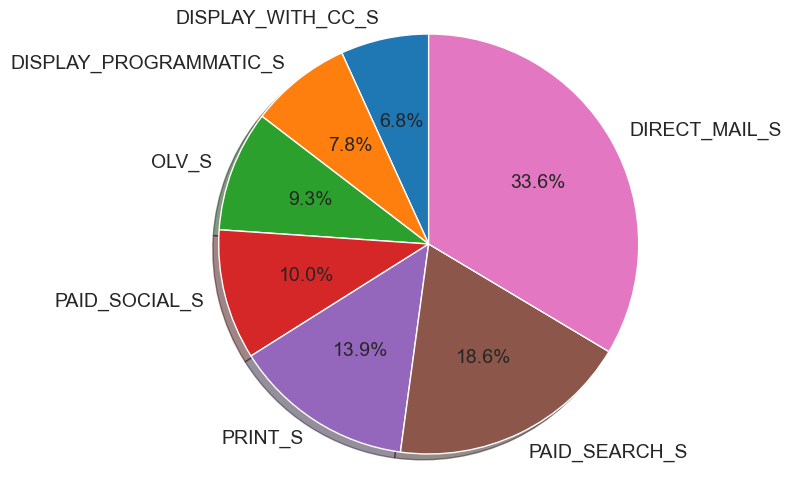

In [80]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df_spend_pie.index.values
sizes = df_spend_pie.values
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90 , textprops={'fontsize': 14})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [81]:
columns_ = ['Display.PHD_Programmatic.S', 'Display.Programmatic_Display.S']
channel_ = 'Programmaatic'

In [82]:
df_filtro = pd.DataFrame(df_Adspend.loc[:, df_Adspend.columns.isin(columns_)])
df_filtro.sum()
                         
                         

Display.PHD_Programmatic.S       2950167.48191
Display.Programmatic_Display.S   1939091.50735
dtype: float64

In [83]:
df_filtro = pd.DataFrame(df_Adspend.loc[:, df_Adspend.columns.isin(columns_)].sum(axis=1))
df_filtro.columns = [channel_]

print(df_filtro.sum().round(2))
df_filtro

Programmaatic   4889258.99000
dtype: float64


,Programmaatic
wk_strt_dt,
2021-04-18,15362.46000
2021-04-25,16923.54000
2021-05-02,12362.01000
2021-05-09,13646.07000
2021-05-16,13559.06000
...,...
2023-04-02,79668.19986
2023-04-09,83269.57988
2023-04-16,88259.87978


### Plot Revenue

In [84]:
df_revenue = df_mmm[['wk_strt_dt', 'revenue']]
df_revenue = df_revenue.set_index('wk_strt_dt')

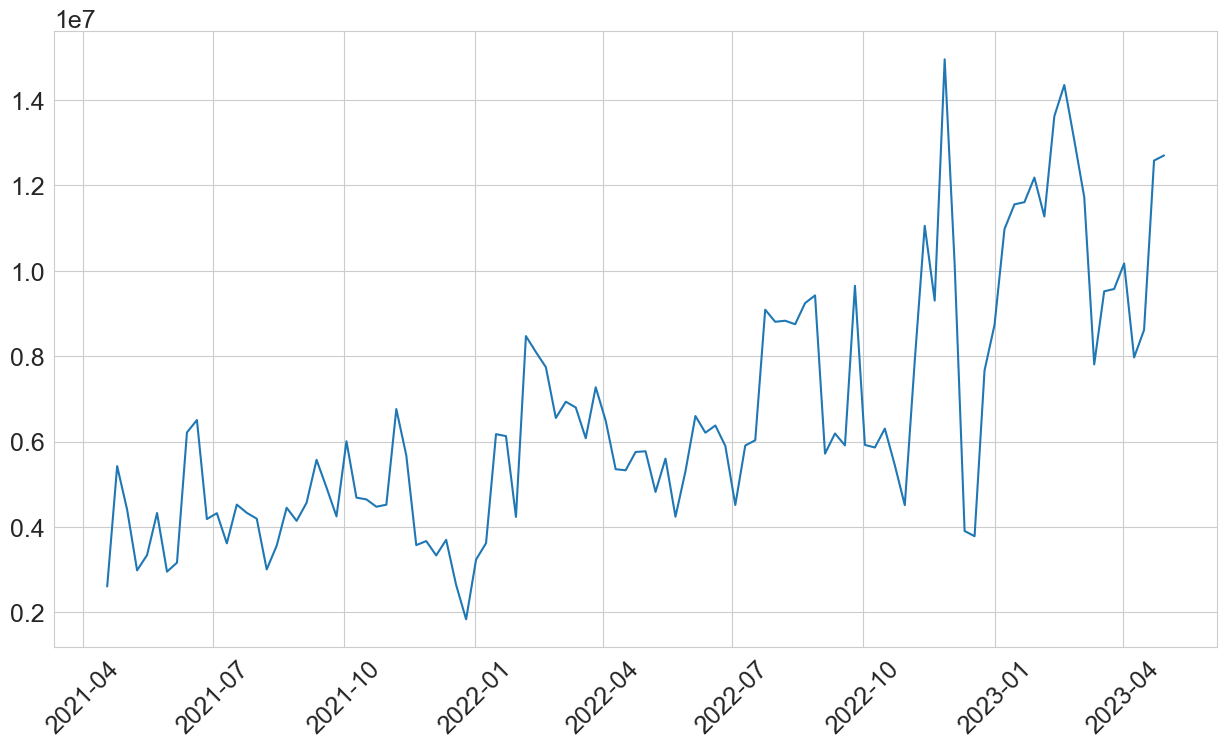

In [85]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees


ax.plot(df_revenue)
plt.show()

#### end----

In [86]:
list_columns = ['wk_strt_dt', 'revenue'] + list_media_spend_vars + list_context_vars
print(len(list_columns))
list_columns

16


['wk_strt_dt',
 'revenue',
 'DIRECT_MAIL_S',
 'PRINT_S',
 'PAID_SEARCH_S',
 'DISPLAY_PROGRAMMATIC_S',
 'DISPLAY_WITH_CC_S',
 'PAID_SOCIAL_S',
 'OLV_S',
 'guests.x',
 'google_trend_SBN',
 'google_trend_COVID',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'retail_and_recreation_percent_change_from_baseline',
 'residential_percent_change_from_baseline']

In [87]:
df_spend = df_mmm.loc[:, (df_mmm.columns.isin( list_media_spend_vars)) ]
data_summary_spend = df_spend.sum()

In [88]:
data_summary_spend

DIRECT_MAIL_S            12687383.43000
PRINT_S                   5255447.79000
PAID_SEARCH_S             7022920.99764
DISPLAY_WITH_CC_S         2566818.32709
DISPLAY_PROGRAMMATIC_S    2950167.48191
PAID_SOCIAL_S             3791796.34937
OLV_S                     3523596.97620
dtype: float64

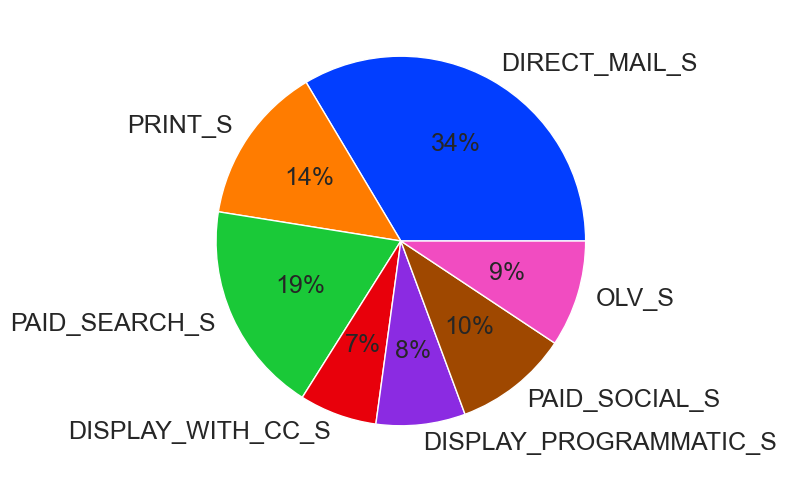

In [89]:
# importing libraries
import matplotlib.pyplot as plt
import seaborn

plt.rcParams["figure.figsize"] = (8,6)

data_list = data_summary_spend.values
data_keys = data_summary_spend.index
  
# define Seaborn color palette to use
palette_color = seaborn.color_palette('bright')
  
# plotting data on chart
plt.pie(data_list, labels=data_keys, colors=palette_color, autopct='%.0f%%')
  
# displaying chart
plt.show()

In [90]:
df_data = df_mmm.loc[:, (df_mmm.columns.isin( list_columns)) ]

df_data = df_data.reset_index(drop=True)


display(df_data.shape)
df_data

(107, 16)

,wk_strt_dt,guests.x,DIRECT_MAIL_S,PRINT_S,PAID_SEARCH_S,DISPLAY_WITH_CC_S,DISPLAY_PROGRAMMATIC_S,PAID_SOCIAL_S,OLV_S,revenue,google_trend_SBN,google_trend_COVID,retail_and_recreation_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2021-04-18,210,79579.54500,55003.41000,49925.56836,17483.49990,15362.46000,61164.81000,0.00000,2610011.21000,35,37,-8.71429,-24.57143,-24.00000,6.14286
1,2021-04-25,463,79579.54500,55003.41000,56868.16599,13966.99640,16923.54000,56578.86000,0.00000,5426183.62000,39,39,-7.42857,-23.28571,-24.14286,5.42857
2,2021-05-02,435,39285.16400,55003.41000,79204.33345,9478.19000,12362.01000,21379.18000,0.00000,4405598.78000,44,31,-5.57143,-22.14286,-23.85714,4.85714
3,2021-05-09,327,39285.16400,20262.25000,66467.87354,12134.36790,13646.07000,47947.58000,0.00000,2986716.83000,31,31,-6.14286,-20.71429,-24.42857,4.71429
4,2021-05-16,304,39285.16400,20262.25000,67393.27239,11067.89960,13559.06000,41426.41000,0.00000,3345103.38000,41,26,-5.57143,-20.57143,-23.28571,4.71429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2023-04-02,1009,112826.20000,100398.60000,74995.45354,3178.60800,39834.09993,52059.12997,49171.42664,10170163.93000,90,4,-8.85714,-16.71429,-18.71429,2.28571
103,2023-04-09,797,112826.20000,100398.60000,73510.62981,4081.71700,41634.78994,61925.65998,96729.00400,7970872.39000,94,4,-8.85714,-16.71429,-19.00000,2.42857
104,2023-04-16,1133,112826.20000,100398.60000,81238.45985,4662.88250,44129.93989,54428.31999,88508.41813,8614044.74000,82,4,-9.57143,-18.57143,-20.28571,3.00000
105,2023-04-23,979,112826.20000,100398.60000,97867.84980,4042.54400,114125.81990,13411.53998,95813.54555,12579093.35000,77,4,-7.85714,-17.57143,-18.85714,2.71429


### Now, we will calculate the profet + holdays

In [91]:
holidays = pd.read_csv("../data/prophet_holidays_daily.csv", parse_dates = ["ds"])

#holidays = pd.read_csv("https://raw.githubusercontent.com/ggandara13/myrepository/master/prophet_holidays_daily.csv",  parse_dates = ["ds"])
    
holidays["begin_week"] = holidays["ds"].dt.to_period('W-SUN').dt.start_time
#combine same week holidays into one holiday
holidays_weekly = holidays.groupby(["begin_week", "country", "year"], as_index = False).agg({'holiday':'#'.join, 'country': 'first', 'year': 'first'}).rename(columns = {'begin_week': 'ds'})
holidays_weekly_us = holidays_weekly.query("(country == 'US')").copy()

holidays_weekly_us['ds'] = pd.DatetimeIndex(holidays_weekly_us['ds']) + pd.DateOffset(-1)

holidays_weekly_us

,ds,holiday,country,year
53,1994-12-25,New Year's Day,US,1995
80,1995-01-01,New Year's Day (Observed),US,1995
89,1995-01-15,Martin Luther King Jr. Day,US,1995
120,1995-02-19,Washington's Birthday,US,1995
382,1995-05-28,Memorial Day,US,1995
...,...,...,...,...
35665,2044-10-09,Columbus Day,US,2044
35720,2044-11-06,Veterans Day,US,2044
35740,2044-11-20,Thanksgiving,US,2044
35821,2044-12-18,Christmas Day,US,2044


In [92]:
prophet_data = df_data.rename(columns = {'revenue': 'y', 'wk_strt_dt': 'ds'})
#add categorical into prophet
#prophet_data = pd.concat([prophet_data, pd.get_dummies(prophet_data["events"], drop_first = True, prefix = "events")], axis = 1)
#prophet_data.tail(30)

In [93]:
holidays_weekly_us[holidays_weekly_us.year==2023]


,ds,holiday,country,year
20121,2022-12-25,New Year's Day,US,2023
20149,2023-01-01,New Year's Day (Observed),US,2023
20164,2023-01-15,Martin Luther King Jr. Day,US,2023
20197,2023-02-19,Washington's Birthday,US,2023
20452,2023-05-28,Memorial Day,US,2023
20511,2023-07-02,Independence Day,US,2023
20595,2023-09-03,Labor Day,US,2023
20646,2023-10-08,Columbus Day,US,2023
20693,2023-11-05,Veterans Day (Observed)#Veterans Day,US,2023
20706,2023-11-19,Thanksgiving,US,2023


In [94]:
prophet = Prophet(yearly_seasonality=True, holidays=holidays_weekly_us)
#prophet.add_regressor(name = "events_event2")
#prophet.add_regressor(name = "events_na")

In [95]:
#prophet_data

In [96]:
prophet.fit(prophet_data[["ds", "y"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y"]])

12:33:51 - cmdstanpy - INFO - Chain [1] start processing
12:33:51 - cmdstanpy - INFO - Chain [1] done processing


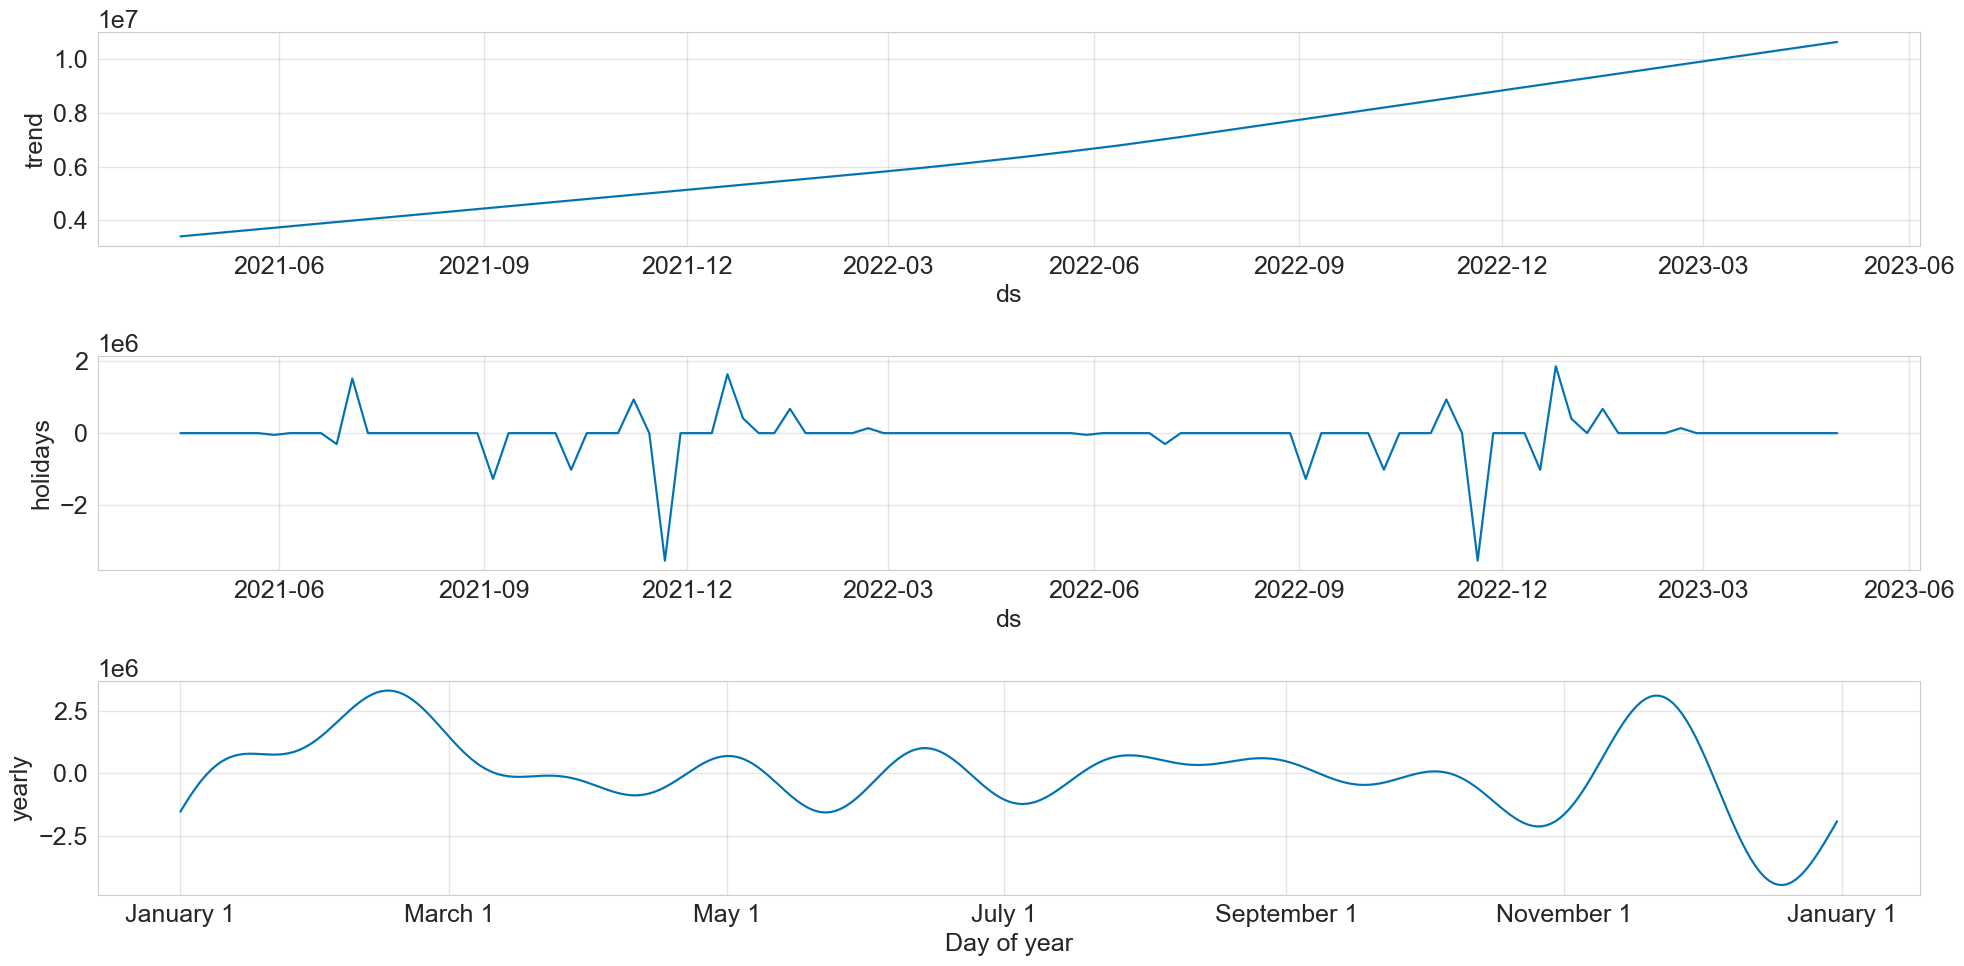

In [97]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [98]:
prophet_predict.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper',
       'Christmas Day (Observed)#Christmas Day',
       'Christmas Day (Observed)#Christmas Day_lower',
       'Christmas Day (Observed)#Christmas Day_upper', 'Columbus Day',
       'Columbus Day_lower', 'Columbus Day_upper', 'Independence Day',
       'Independence Day_lower', 'Independence Day_upper',
       'Independence Day (Observed)', 'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper',
       'Independence Day (Observed)#Independence Day',
       'Independence Day (Observed)#Independence Day_lower',
       'Independence Day (Observed)#Independence Day_upper', 'Labor Day',
       'Labor Day_lower', 'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin 

In [99]:
prophet_predict.trend.describe()

count        107.00000
mean     6623810.79583
std      2117363.75159
min      3410700.01747
25%      4823313.94958
50%      6299618.73054
75%      8402704.41166
max     10629292.61104
Name: trend, dtype: float64

In [100]:
prophet_predict.yearly

0      -490499.42036
1       314491.56169
2       693405.84020
3        95699.85692
4     -1015026.49701
           ...      
102    -428269.18398
103    -828273.86996
104    -705384.42784
105      26817.85230
106     660033.62703
Name: yearly, Length: 107, dtype: float64

In [101]:
prophet_predict.shape

(107, 70)

In [102]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]
#events_numeric = prophet_predict[prophet_columns].filter(like = "events_").sum(axis = 1)


final_data = df_data.copy()
final_data["seas_trend"] = prophet_predict["trend"]
final_data["seas_season"] = prophet_predict["yearly"]
final_data["holiday"] = prophet_predict["holidays"]

In [103]:
final_data.shape

(107, 19)

In [104]:
df_data

,wk_strt_dt,guests.x,DIRECT_MAIL_S,PRINT_S,PAID_SEARCH_S,DISPLAY_WITH_CC_S,DISPLAY_PROGRAMMATIC_S,PAID_SOCIAL_S,OLV_S,revenue,google_trend_SBN,google_trend_COVID,retail_and_recreation_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2021-04-18,210,79579.54500,55003.41000,49925.56836,17483.49990,15362.46000,61164.81000,0.00000,2610011.21000,35,37,-8.71429,-24.57143,-24.00000,6.14286
1,2021-04-25,463,79579.54500,55003.41000,56868.16599,13966.99640,16923.54000,56578.86000,0.00000,5426183.62000,39,39,-7.42857,-23.28571,-24.14286,5.42857
2,2021-05-02,435,39285.16400,55003.41000,79204.33345,9478.19000,12362.01000,21379.18000,0.00000,4405598.78000,44,31,-5.57143,-22.14286,-23.85714,4.85714
3,2021-05-09,327,39285.16400,20262.25000,66467.87354,12134.36790,13646.07000,47947.58000,0.00000,2986716.83000,31,31,-6.14286,-20.71429,-24.42857,4.71429
4,2021-05-16,304,39285.16400,20262.25000,67393.27239,11067.89960,13559.06000,41426.41000,0.00000,3345103.38000,41,26,-5.57143,-20.57143,-23.28571,4.71429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2023-04-02,1009,112826.20000,100398.60000,74995.45354,3178.60800,39834.09993,52059.12997,49171.42664,10170163.93000,90,4,-8.85714,-16.71429,-18.71429,2.28571
103,2023-04-09,797,112826.20000,100398.60000,73510.62981,4081.71700,41634.78994,61925.65998,96729.00400,7970872.39000,94,4,-8.85714,-16.71429,-19.00000,2.42857
104,2023-04-16,1133,112826.20000,100398.60000,81238.45985,4662.88250,44129.93989,54428.31999,88508.41813,8614044.74000,82,4,-9.57143,-18.57143,-20.28571,3.00000
105,2023-04-23,979,112826.20000,100398.60000,97867.84980,4042.54400,114125.81990,13411.53998,95813.54555,12579093.35000,77,4,-7.85714,-17.57143,-18.85714,2.71429


In [105]:
#final_data.to_csv('/Users/gerardogandara/Documents/MMX/MMM_SBN_ready.csv', index=False)

In [106]:
final_data.seas_trend.tail(80)

27     4849967.04322
28     4903273.23087
29     4956579.41852
30     5009885.60617
31     5063191.83981
           ...      
102   10293203.82616
103   10377226.02238
104   10461248.21860
105   10545270.41482
106   10629292.61104
Name: seas_trend, Length: 80, dtype: float64

In [107]:
final_data

,wk_strt_dt,guests.x,DIRECT_MAIL_S,PRINT_S,PAID_SEARCH_S,DISPLAY_WITH_CC_S,DISPLAY_PROGRAMMATIC_S,PAID_SOCIAL_S,OLV_S,revenue,google_trend_SBN,google_trend_COVID,retail_and_recreation_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,seas_trend,seas_season,holiday
0,2021-04-18,210,79579.54500,55003.41000,49925.56836,17483.49990,15362.46000,61164.81000,0.00000,2610011.21000,35,37,-8.71429,-24.57143,-24.00000,6.14286,3410700.01747,-490499.42036,0.00000
1,2021-04-25,463,79579.54500,55003.41000,56868.16599,13966.99640,16923.54000,56578.86000,0.00000,5426183.62000,39,39,-7.42857,-23.28571,-24.14286,5.42857,3464006.20254,314491.56169,0.00000
2,2021-05-02,435,39285.16400,55003.41000,79204.33345,9478.19000,12362.01000,21379.18000,0.00000,4405598.78000,44,31,-5.57143,-22.14286,-23.85714,4.85714,3517312.38760,693405.84020,0.00000
3,2021-05-09,327,39285.16400,20262.25000,66467.87354,12134.36790,13646.07000,47947.58000,0.00000,2986716.83000,31,31,-6.14286,-20.71429,-24.42857,4.71429,3570618.57266,95699.85692,0.00000
4,2021-05-16,304,39285.16400,20262.25000,67393.27239,11067.89960,13559.06000,41426.41000,0.00000,3345103.38000,41,26,-5.57143,-20.57143,-23.28571,4.71429,3623924.75792,-1015026.49701,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2023-04-02,1009,112826.20000,100398.60000,74995.45354,3178.60800,39834.09993,52059.12997,49171.42664,10170163.93000,90,4,-8.85714,-16.71429,-18.71429,2.28571,10293203.82616,-428269.18398,0.00000
103,2023-04-09,797,112826.20000,100398.60000,73510.62981,4081.71700,41634.78994,61925.65998,96729.00400,7970872.39000,94,4,-8.85714,-16.71429,-19.00000,2.42857,10377226.02238,-828273.86996,0.00000
104,2023-04-16,1133,112826.20000,100398.60000,81238.45985,4662.88250,44129.93989,54428.31999,88508.41813,8614044.74000,82,4,-9.57143,-18.57143,-20.28571,3.00000,10461248.21860,-705384.42784,0.00000
105,2023-04-23,979,112826.20000,100398.60000,97867.84980,4042.54400,114125.81990,13411.53998,95813.54555,12579093.35000,77,4,-7.85714,-17.57143,-18.85714,2.71429,10545270.41482,26817.85230,0.00000


In [108]:
print("MIN Date:", final_data.wk_strt_dt.min())
print("MAX Date:", final_data.wk_strt_dt.max())
print("106 week")

MIN Date: 2021-04-18 00:00:00
MAX Date: 2023-04-30 00:00:00
106 week


# PYMC3

In [109]:
import pandas as pd
import numpy as np
import math
import sys
import os


pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
import seaborn as sns

from scipy.stats.mstats import mquantiles

from plotnine import *

#from numerize import numerize

In [110]:
import pymc3 as pm

import arviz as az


import theano
import theano.tensor as tt

In [111]:
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.5


In [112]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [113]:
from scipy import optimize
from prophet import Prophet


In [114]:
START_ANALYSIS_INDEX = 1
END_ANALYSIS_INDEX = 106


In [115]:
#START_ANALYSIS_INDEX = 52
#END_ANALYSIS_INDEX = 144


In [116]:
final_data

,wk_strt_dt,guests.x,DIRECT_MAIL_S,PRINT_S,PAID_SEARCH_S,DISPLAY_WITH_CC_S,DISPLAY_PROGRAMMATIC_S,PAID_SOCIAL_S,OLV_S,revenue,google_trend_SBN,google_trend_COVID,retail_and_recreation_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,seas_trend,seas_season,holiday
0,2021-04-18,210,79579.54500,55003.41000,49925.56836,17483.49990,15362.46000,61164.81000,0.00000,2610011.21000,35,37,-8.71429,-24.57143,-24.00000,6.14286,3410700.01747,-490499.42036,0.00000
1,2021-04-25,463,79579.54500,55003.41000,56868.16599,13966.99640,16923.54000,56578.86000,0.00000,5426183.62000,39,39,-7.42857,-23.28571,-24.14286,5.42857,3464006.20254,314491.56169,0.00000
2,2021-05-02,435,39285.16400,55003.41000,79204.33345,9478.19000,12362.01000,21379.18000,0.00000,4405598.78000,44,31,-5.57143,-22.14286,-23.85714,4.85714,3517312.38760,693405.84020,0.00000
3,2021-05-09,327,39285.16400,20262.25000,66467.87354,12134.36790,13646.07000,47947.58000,0.00000,2986716.83000,31,31,-6.14286,-20.71429,-24.42857,4.71429,3570618.57266,95699.85692,0.00000
4,2021-05-16,304,39285.16400,20262.25000,67393.27239,11067.89960,13559.06000,41426.41000,0.00000,3345103.38000,41,26,-5.57143,-20.57143,-23.28571,4.71429,3623924.75792,-1015026.49701,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2023-04-02,1009,112826.20000,100398.60000,74995.45354,3178.60800,39834.09993,52059.12997,49171.42664,10170163.93000,90,4,-8.85714,-16.71429,-18.71429,2.28571,10293203.82616,-428269.18398,0.00000
103,2023-04-09,797,112826.20000,100398.60000,73510.62981,4081.71700,41634.78994,61925.65998,96729.00400,7970872.39000,94,4,-8.85714,-16.71429,-19.00000,2.42857,10377226.02238,-828273.86996,0.00000
104,2023-04-16,1133,112826.20000,100398.60000,81238.45985,4662.88250,44129.93989,54428.31999,88508.41813,8614044.74000,82,4,-9.57143,-18.57143,-20.28571,3.00000,10461248.21860,-705384.42784,0.00000
105,2023-04-23,979,112826.20000,100398.60000,97867.84980,4042.54400,114125.81990,13411.53998,95813.54555,12579093.35000,77,4,-7.85714,-17.57143,-18.85714,2.71429,10545270.41482,26817.85230,0.00000


## Non-linear parameter estimation

In [117]:
spend_to_exposure_menten_func = lambda spend, V_max, K_m: V_max * spend / (K_m + spend)
exposure_to_spend_menten_func = lambda exposure, V_max, K_m: exposure * K_m / (V_max - exposure)

In [118]:
media_exposures = []
#media_exposures = ['guests.x']

media_spends = list_media_spend_vars

media_spend_exposure_df = pd.DataFrame()
for (media_exposure, media_spend) in zip(media_exposures, media_spends):
    V_max = final_data[media_exposure].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX].max()
    K_m   = V_max / 2
    spend = final_data[media_spend].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX]
    exposure = final_data[media_exposure].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX]
    best_values, _ = optimize.curve_fit(f = spend_to_exposure_menten_func, xdata = spend, ydata = exposure, p0 = [V_max, K_m])
    media_spend_exposure_df = pd.concat([media_spend_exposure_df, pd.DataFrame({'spend': [media_spend], 'exposure': [media_exposure], 'V_max': [best_values[0]], 'K_m': [best_values[1]]})]).reset_index(drop = True)
    
media_spend_exposure_df

""


In [119]:
media_spends

['DIRECT_MAIL_S',
 'PRINT_S',
 'PAID_SEARCH_S',
 'DISPLAY_PROGRAMMATIC_S',
 'DISPLAY_WITH_CC_S',
 'PAID_SOCIAL_S',
 'OLV_S']

# Bayesian Marketing Mix Modeling using pymc3


In [120]:
data = final_data

In [121]:
def adstock_geometric(x: float, theta: float):
    x_decayed = np.zeros_like(x)
    x_decayed[0] = x[0]
                               
    for xi in range(1, len(x_decayed)):
        x_decayed[xi] = x[xi] + theta * x_decayed[xi - 1]

    return x_decayed

def adstock_geometric_theano_pymc3(x, theta):
    x = tt.as_tensor_variable(x)
    #x = tt.vector("x")
    #theta = tt.scalar("theta")

    def adstock_geometric_recurrence_theano(index, input_x, decay_x, theta):
        return tt.set_subtensor(decay_x[index], tt.sum(input_x + theta * decay_x[index - 1]))

    len_observed = x.shape[0]

    x_decayed = tt.zeros_like(x)
    x_decayed = tt.set_subtensor(x_decayed[0], x[0])

    output, _ = theano.scan(
        fn = adstock_geometric_recurrence_theano, 
        sequences = [tt.arange(1, len_observed), x[1:len_observed]], 
        outputs_info = x_decayed,
        non_sequences = theta, 
        n_steps = len_observed - 1
    )
    
    return output[-1]


def saturation_hill_pymc3(x, alpha, gamma): 
    
    x_s_hill = x ** alpha / (x ** alpha + gamma ** alpha)
    
    return x_s_hill


#from https://github.com/ikatsov/tensor-house/blob/master/promotions/mediamix-bayesian.ipynb

#plots priors using the random variables
def plot_priors(variables, prior_dictionary = None):
    if isinstance(variables[0], pm.model.TransformedRV) == False and prior_dictionary is None:
        raise Exception("prior dictionary should be provided. It can be generated by sample_prior_predictive")
    cols = 2
    rows = int(math.ceil(len(variables)/cols))
    fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
    ax = np.reshape(ax, (-1, cols))
    for i in range(rows):
         for j in range(cols):
            vi = i*cols + j
            if vi < len(variables):
                var = variables[vi]
                if isinstance(var, pm.model.TransformedRV):
                    sns.histplot(var.random(size=10000).flatten(), kde=True, ax=ax[i, j])
                    #p.set_axis_labels(var.name)
                    ax[i, j].set_title(var.name)
                else:
                    prior = prior_dictionary[var]
                    sns.histplot(prior, kde=True, ax = ax[i, j])
                    ax[i, j].set_title(var)
    plt.tight_layout()
    
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))


def plot_residuals(actual_vs_predicted: pd.DataFrame, figure_size = (15, 10)):
    """Residual plot

    Args:
        actual_vs_predicted (pd.DataFrame): Data Frame with three columns: date, actual, predicted
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).
    """
    
    plt = ggplot(actual_vs_predicted, aes("predicted", y = "actual - predicted"))\
    + geom_point(size = 2, show_legend = True)\
    + geom_hline(yintercept = 0, linetype = "dashed")\
    + geom_smooth(se=True, method = "loess", color = "blue")\
    + ggtitle("Actuals vs. predicted response") + xlab("predicted") + ylab("residual")\
    + theme(figure_size = figure_size,
                        legend_direction='horizontal', 
                        legend_position= "bottom",
                        legend_box_spacing=0.5,
                        legend_key_size=20, 
                        legend_entry_spacing_y=10, 
                        axis_text_y=element_text(weight="bold", size = 10)
        ) 
    
    return plt   


def plot_spend_vs_effect_share(decomp_spend: pd.DataFrame, figure_size = (15, 10)):
    """Spend vs Effect Share plot

    Args:
        decomp_spend (pd.DataFrame): Data with media decompositions. The following columns should be present:
        media, spend_share, effect_share per media variable
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).

    Example:
        decomp_spend:
        media         spend_share effect_share
        tv_S           0.31        0.44
        ooh_S          0.23        0.34
    
    Returns:
        [plotnine]: plotnine plot
    """
    
    plot_spend_effect_share = decomp_spend.melt(id_vars = ["media"], value_vars = ["spend_share", "effect_share"])

    plt = ggplot(plot_spend_effect_share, aes("media", "value", fill = "variable")) \
    + geom_bar(stat = "identity", position = "dodge") \
    + geom_text(aes(label = "value * 100", group = "variable"), color = "darkblue", position=position_dodge(width = 0.5), format_string = "{:.2f}%") \
    + coord_flip() \
    + ggtitle("Share of Spend VS Share of Effect") + ylab("") + xlab("") \
    + theme(figure_size = figure_size, 
                    legend_direction='vertical', 
                    legend_title=element_blank(),
                    legend_key_size=20, 
                    legend_entry_spacing_y=5) 
    return plt

### Dependent Treansformation is divided by 100K


In [122]:
list_columns

['wk_strt_dt',
 'revenue',
 'DIRECT_MAIL_S',
 'PRINT_S',
 'PAID_SEARCH_S',
 'DISPLAY_PROGRAMMATIC_S',
 'DISPLAY_WITH_CC_S',
 'PAID_SOCIAL_S',
 'OLV_S',
 'guests.x',
 'google_trend_SBN',
 'google_trend_COVID',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'retail_and_recreation_percent_change_from_baseline',
 'residential_percent_change_from_baseline']

In [124]:
transform_variables = [
    "seas_trend", 
    "seas_season", 
    "holiday", 
    'guests.x',
    'google_trend_SBN',
    'google_trend_COVID',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'retail_and_recreation_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    
 'DIRECT_MAIL_S',
 'PRINT_S',
 'PAID_SEARCH_S',
 'DISPLAY_PROGRAMMATIC_S',
 'DISPLAY_WITH_CC_S',
 'PAID_SOCIAL_S',
 'OLV_S']


delay_channels = [
 'DIRECT_MAIL_S',
 'PRINT_S',
 'PAID_SEARCH_S',
 'DISPLAY_PROGRAMMATIC_S',
 'DISPLAY_WITH_CC_S',
 'PAID_SOCIAL_S',
 'OLV_S']

media_channels = [
 'DIRECT_MAIL_S',
 'PRINT_S',
 'PAID_SEARCH_S',
 'DISPLAY_PROGRAMMATIC_S',
 'DISPLAY_WITH_CC_S',
 'PAID_SOCIAL_S',
 'OLV_S']

control_variables = [
    "seas_trend", 
    "seas_season", 
    "holiday", 
    'guests.x',
    'google_trend_SBN',
    'google_trend_COVID',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'retail_and_recreation_percent_change_from_baseline',
    'residential_percent_change_from_baseline'
]

target = "revenue"

data_transformed = data.copy()

numerical_encoder_dict = {}

for feature in transform_variables:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

dependent_transformation = None
original = data[target].values
data_transformed[target] = original / 100_000
    
response_mean = []
with pm.Model() as model_2:
    for channel_name in delay_channels:
        print(f"Delay Channels: Adding {channel_name}")
        
        x = data_transformed[channel_name].values
        
        
        
        adstock_param = pm.Beta(f"{channel_name}_adstock", 3, 3)
        saturation_gamma = pm.Beta(f"{channel_name}_gamma", 2, 2)
        saturation_alpha = pm.Gamma(f"{channel_name}_alpha", 3, 1)
        
        x_new = adstock_geometric_theano_pymc3(x, adstock_param)
        x_new_sliced = x_new[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        saturation_tensor = saturation_hill_pymc3(x_new_sliced, saturation_alpha, saturation_gamma)
        
        channel_b = pm.HalfNormal(f"{channel_name}_media_coef", sd = 3)
        response_mean.append(saturation_tensor * channel_b)
        
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        
        x = data_transformed[control_var].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        
        control_beta = pm.Normal(f"{control_var}_control_coef", sd = 3)
        control_x = control_beta * x
        response_mean.append(control_x)
        
    intercept = pm.Normal("intercept", np.mean(data_transformed[target].values), sd = 3)
    #intercept = pm.HalfNormal("intercept", 0, sd = 3)
        
    sigma = pm.HalfNormal("sigma", 4)
    
    likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sd = sigma, observed = data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])

print("\n---- Process completed ---- \n")

Delay Channels: Adding DIRECT_MAIL_S
Delay Channels: Adding PRINT_S
Delay Channels: Adding PAID_SEARCH_S
Delay Channels: Adding DISPLAY_PROGRAMMATIC_S
Delay Channels: Adding DISPLAY_WITH_CC_S
Delay Channels: Adding PAID_SOCIAL_S
Delay Channels: Adding OLV_S
Control Variables: Adding seas_trend
Control Variables: Adding seas_season
Control Variables: Adding holiday
Control Variables: Adding guests.x
Control Variables: Adding google_trend_SBN
Control Variables: Adding google_trend_COVID
Control Variables: Adding transit_stations_percent_change_from_baseline
Control Variables: Adding workplaces_percent_change_from_baseline
Control Variables: Adding retail_and_recreation_percent_change_from_baseline
Control Variables: Adding residential_percent_change_from_baseline

---- Process completed ---- 



In [126]:
transform_variables = [
    #'holiday', 
    'seas_trend', 
    'seas_season',
    'guests.x',
    'google_trend_SBN',
    'google_trend_COVID',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'retail_and_recreation_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    'DIRECT_MAIL_S',
    'PRINT_S',
    'PAID_SEARCH_S',
    'DISPLAY_PROGRAMMATIC_S',
    'DISPLAY_WITH_CC_S',
    'PAID_SOCIAL_S',
    'OLV_S']


delay_channels = [
    'DIRECT_MAIL_S',
    'PRINT_S',
    'PAID_SEARCH_S',
    'DISPLAY_PROGRAMMATIC_S',
    'DISPLAY_WITH_CC_S',
    'PAID_SOCIAL_S',
    'OLV_S']

media_channels = [
    'DIRECT_MAIL_S',
    'PRINT_S',
    'PAID_SEARCH_S',
    'DISPLAY_PROGRAMMATIC_S',
    'DISPLAY_WITH_CC_S',
    'PAID_SOCIAL_S',
    'OLV_S']

control_variables = [
    'seas_trend', 
    'seas_season',
    'guests.x',
    'google_trend_SBN',
    'google_trend_COVID',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'retail_and_recreation_percent_change_from_baseline',
    'residential_percent_change_from_baseline']

target = "revenue"

data_transformed = data.copy()

numerical_encoder_dict = {}

for feature in transform_variables:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

dependent_transformation = None
original = data[target].values
data_transformed[target] = original / 100_000
    
response_mean = []
with pm.Model() as model_2:
    for channel_name in delay_channels:
        print(f"Delay Channels: Adding {channel_name}")
        
        x = data_transformed[channel_name].values
        
        
        
        adstock_param = pm.Beta(f"{channel_name}_adstock", 3, 3)
        saturation_gamma = pm.Beta(f"{channel_name}_gamma", 2, 2)
        saturation_alpha = pm.Gamma(f"{channel_name}_alpha", 3, 1)
        
        x_new = adstock_geometric_theano_pymc3(x, adstock_param)
        x_new_sliced = x_new[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        saturation_tensor = saturation_hill_pymc3(x_new_sliced, saturation_alpha, saturation_gamma)
        
        channel_b = pm.HalfNormal(f"{channel_name}_media_coef", sd = 3)
        response_mean.append(saturation_tensor * channel_b)
        
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        
        x = data_transformed[control_var].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        
        control_beta = pm.Normal(f"{control_var}_control_coef", sd = 3)
        control_x = control_beta * x
        response_mean.append(control_x)
        
    intercept = pm.Normal("intercept", np.mean(data_transformed[target].values), sd = 3)
    #intercept = pm.HalfNormal("intercept", 0, sd = 3)
        
    sigma = pm.HalfNormal("sigma", 4)
    
    likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sd = sigma, observed = data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])

print("\n---- Process completed ---- \n")

Delay Channels: Adding DIRECT_MAIL_S
Delay Channels: Adding PRINT_S
Delay Channels: Adding PAID_SEARCH_S
Delay Channels: Adding DISPLAY_PROGRAMMATIC_S
Delay Channels: Adding DISPLAY_WITH_CC_S
Delay Channels: Adding PAID_SOCIAL_S
Delay Channels: Adding OLV_S
Control Variables: Adding seas_trend
Control Variables: Adding seas_season
Control Variables: Adding guests.x
Control Variables: Adding google_trend_SBN
Control Variables: Adding google_trend_COVID
Control Variables: Adding transit_stations_percent_change_from_baseline
Control Variables: Adding workplaces_percent_change_from_baseline
Control Variables: Adding retail_and_recreation_percent_change_from_baseline
Control Variables: Adding residential_percent_change_from_baseline

---- Process completed ---- 



In [127]:
transform_variables = [
    #"seas_trend", "seas_season", "holiday", 
    'DIRECT_MAIL_S',
    'PRINT_S',
    'PAID_SEARCH_S',
    'DISPLAY_PROGRAMMATIC_S',
    'DISPLAY_WITH_CC_S',
    'PAID_SOCIAL_S',
    'OLV_S']


delay_channels = [
 'DIRECT_MAIL_S',
 'PRINT_S',
 'PAID_SEARCH_S',
 'DISPLAY_PROGRAMMATIC_S',
 'DISPLAY_WITH_CC_S',
 'PAID_SOCIAL_S',
 'OLV_S']

media_channels = ['DIRECT_MAIL_S',
 'PRINT_S',
 'PAID_SEARCH_S',
 'DISPLAY_PROGRAMMATIC_S',
 'DISPLAY_WITH_CC_S',
 'PAID_SOCIAL_S',
 'OLV_S']

control_variables = [
    #'seas_trend', 
    #"seas_season", 
    #"holiday",
 'guests.x',
 'google_trend_SBN',
 'google_trend_COVID',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'retail_and_recreation_percent_change_from_baseline',
 'residential_percent_change_from_baseline']

target = "revenue"

data_transformed = data.copy()

numerical_encoder_dict = {}

for feature in transform_variables:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

dependent_transformation = None
original = data[target].values
data_transformed[target] = original / 100_000
    
response_mean = []
with pm.Model() as model_2:
    for channel_name in delay_channels:
        print(f"Delay Channels: Adding {channel_name}")
        
        x = data_transformed[channel_name].values
        
        
        
        adstock_param = pm.Beta(f"{channel_name}_adstock", 3, 3)
        saturation_gamma = pm.Beta(f"{channel_name}_gamma", 2, 2)
        saturation_alpha = pm.Gamma(f"{channel_name}_alpha", 3, 1)
        
        x_new = adstock_geometric_theano_pymc3(x, adstock_param)
        x_new_sliced = x_new[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        saturation_tensor = saturation_hill_pymc3(x_new_sliced, saturation_alpha, saturation_gamma)
        
        channel_b = pm.HalfNormal(f"{channel_name}_media_coef", sd = 3)
        response_mean.append(saturation_tensor * channel_b)
        
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        
        x = data_transformed[control_var].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        
        control_beta = pm.Normal(f"{control_var}_control_coef", sd = 3)
        control_x = control_beta * x
        response_mean.append(control_x)
        
    intercept = pm.Normal("intercept", np.mean(data_transformed[target].values), sd = 3)
    #intercept = pm.HalfNormal("intercept", 0, sd = 3)
        
    sigma = pm.HalfNormal("sigma", 4)
    
    likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sd = sigma, observed = data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])
 
print("\n---- Process completed ---- \n")

Delay Channels: Adding DIRECT_MAIL_S
Delay Channels: Adding PRINT_S
Delay Channels: Adding PAID_SEARCH_S
Delay Channels: Adding DISPLAY_PROGRAMMATIC_S
Delay Channels: Adding DISPLAY_WITH_CC_S
Delay Channels: Adding PAID_SOCIAL_S
Delay Channels: Adding OLV_S
Control Variables: Adding guests.x
Control Variables: Adding google_trend_SBN
Control Variables: Adding google_trend_COVID
Control Variables: Adding transit_stations_percent_change_from_baseline
Control Variables: Adding workplaces_percent_change_from_baseline
Control Variables: Adding retail_and_recreation_percent_change_from_baseline
Control Variables: Adding residential_percent_change_from_baseline

---- Process completed ---- 



In [128]:
START_ANALYSIS_INDEX

1

In [129]:
END_ANALYSIS_INDEX

106

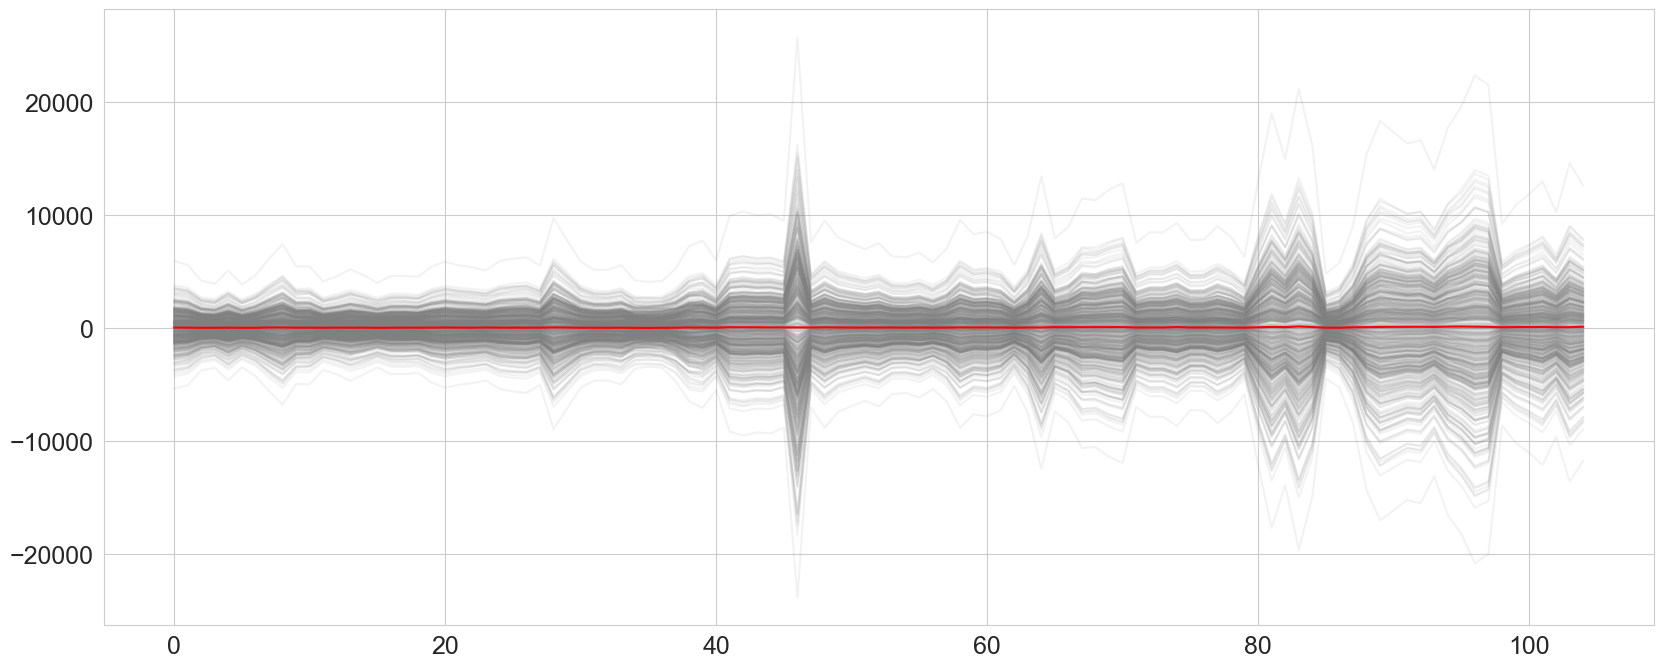

In [130]:
with model_2:
    prior_pred = pm.sample_prior_predictive()
    
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["outcome"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], color = "red")

In [131]:
END_ANALYSIS_INDEX

106

In [132]:
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]
len(prior_names)


38

adstock priors: 7
alpha priors: 7
gamma priors: 7
media coef priors: 7
control coef priors: 8
sigma prior: 1


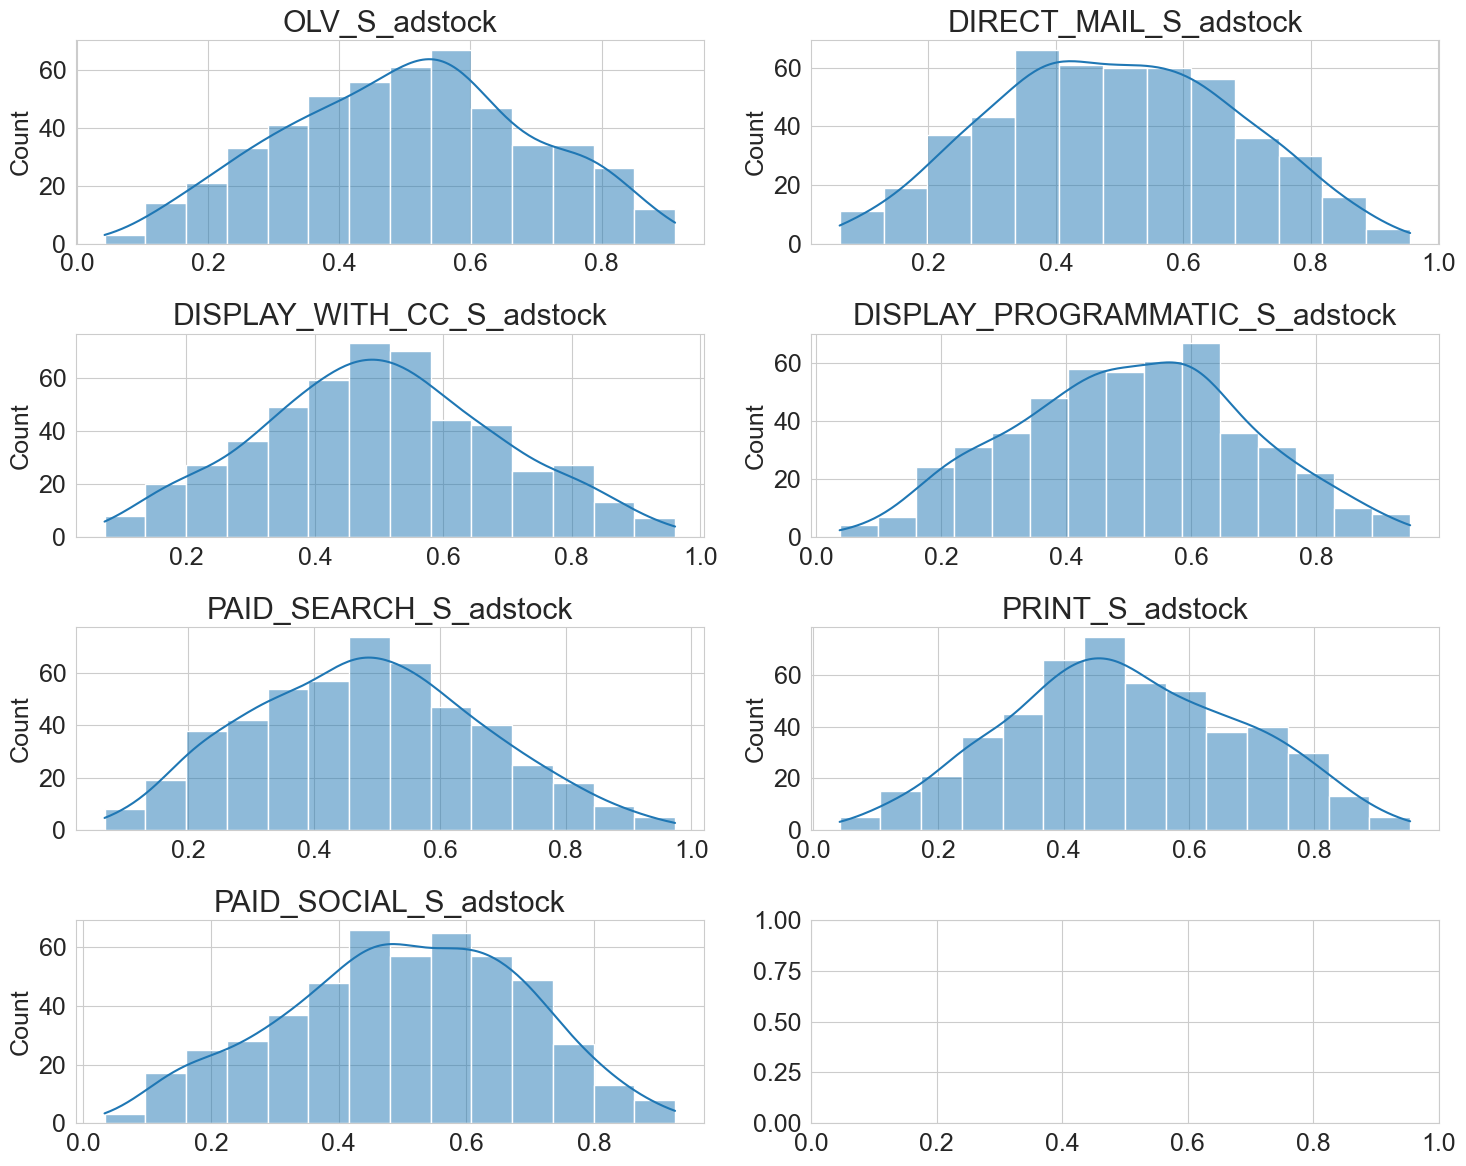

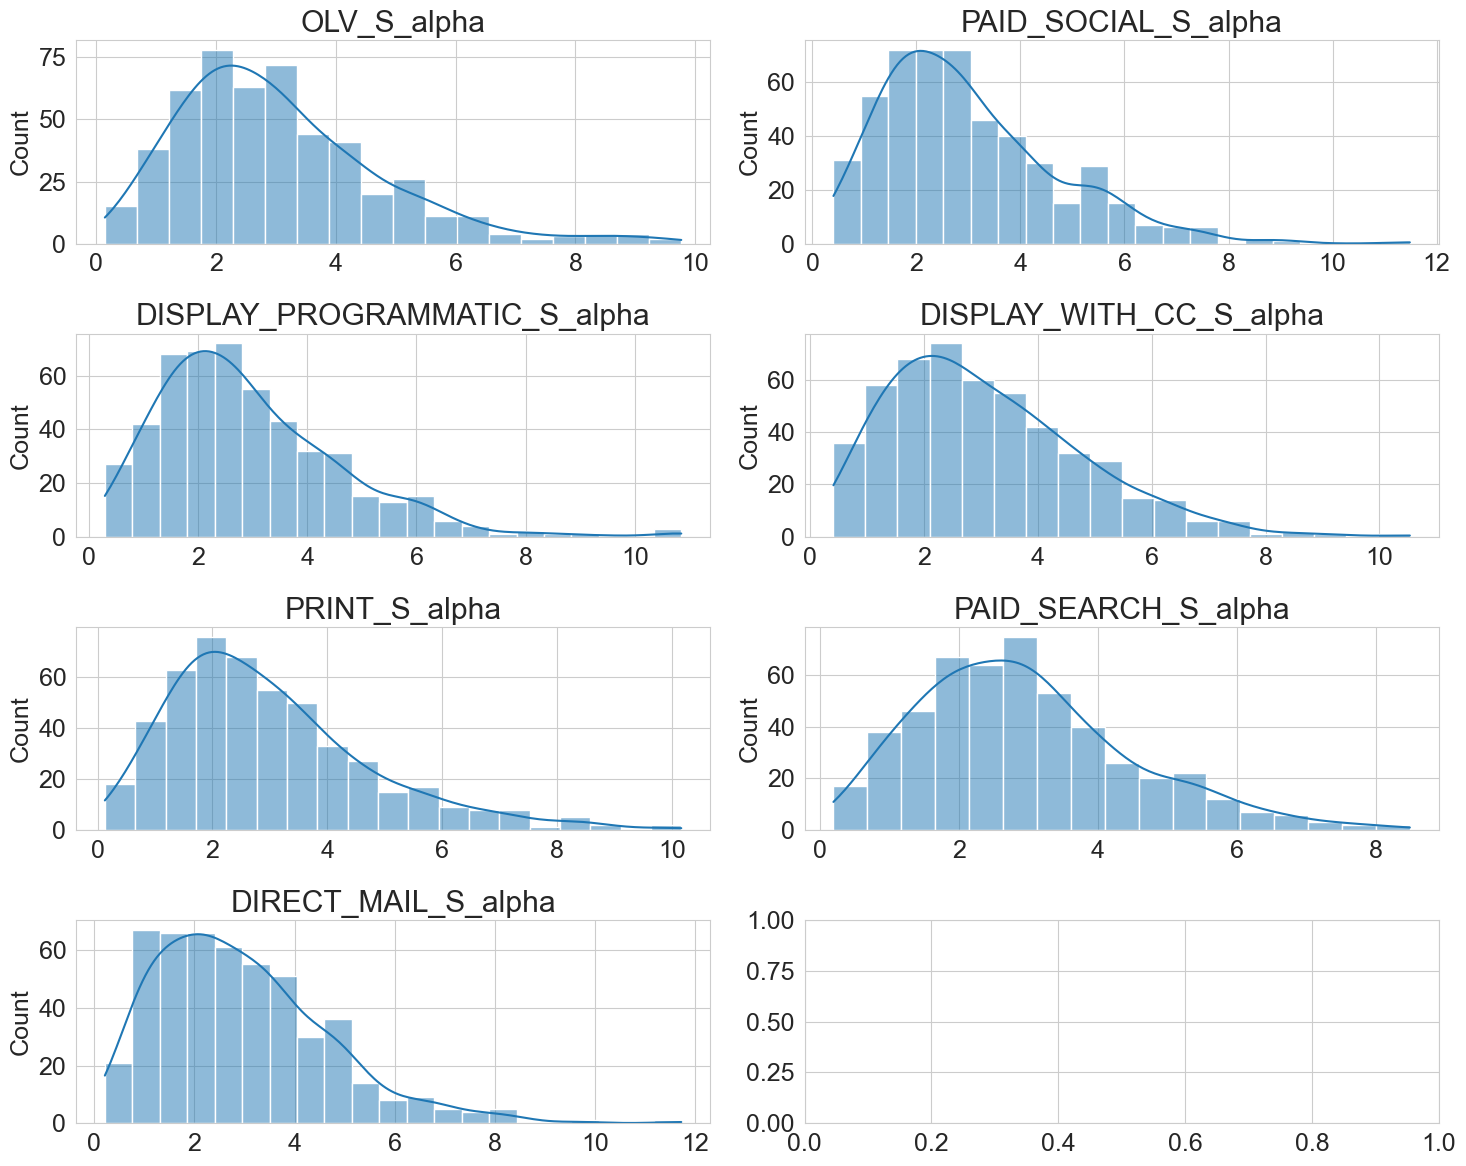

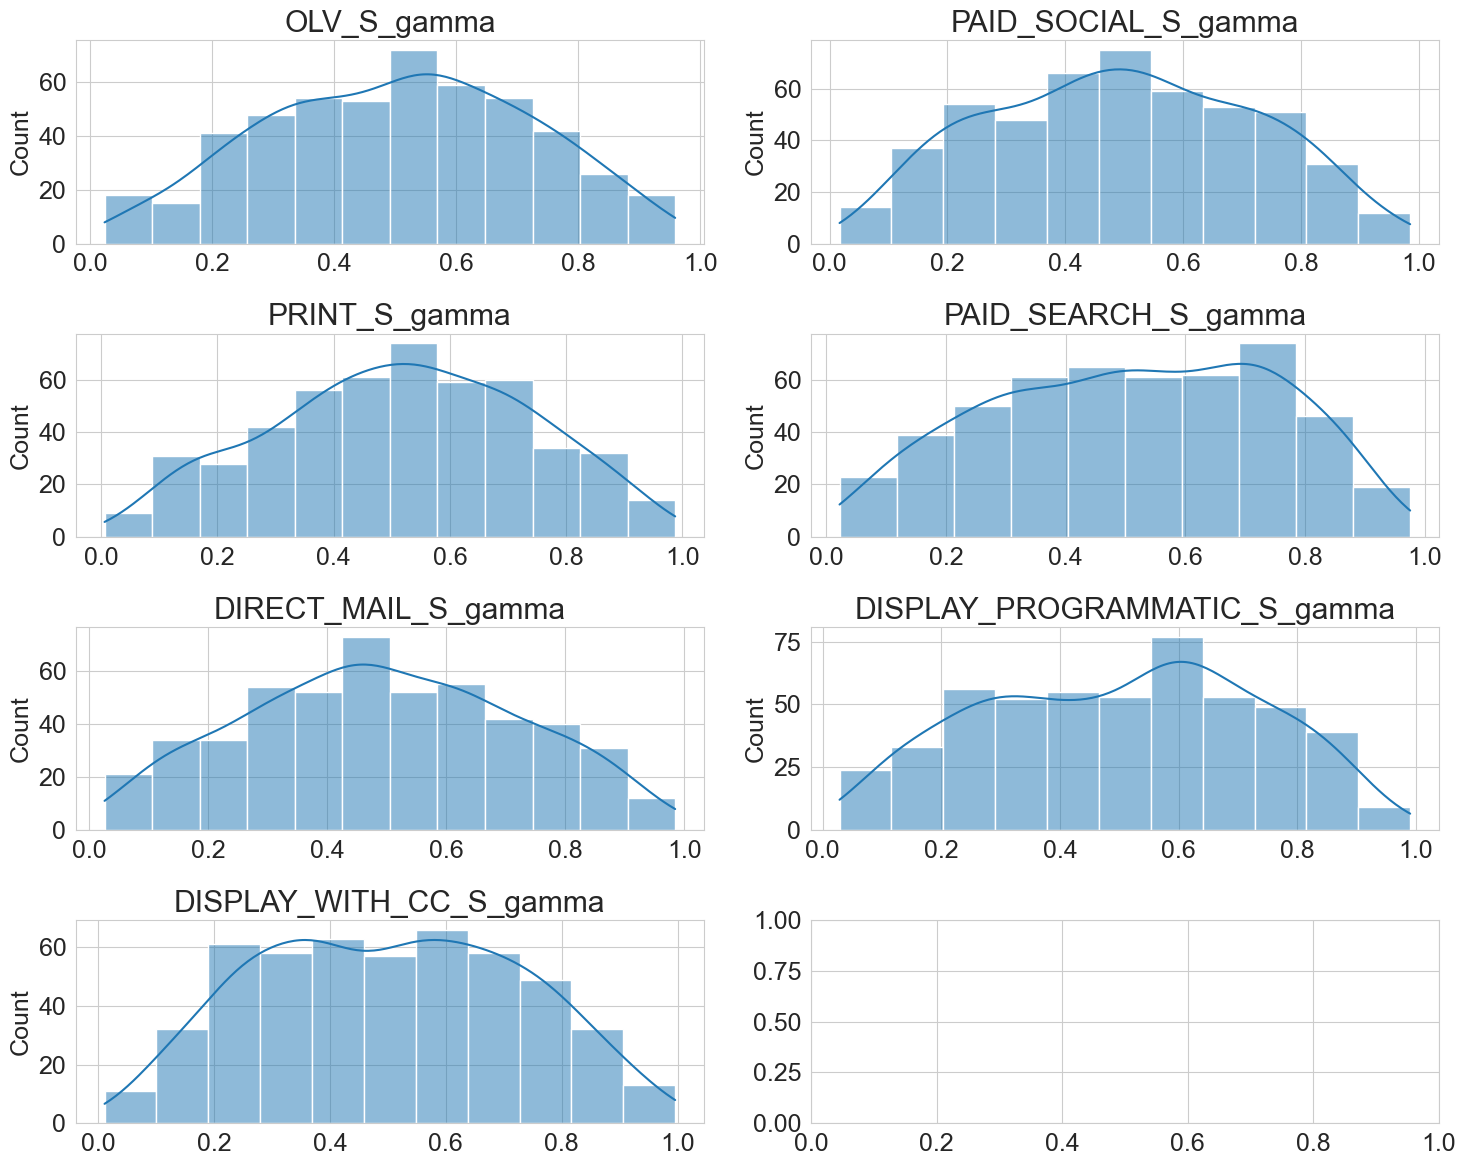

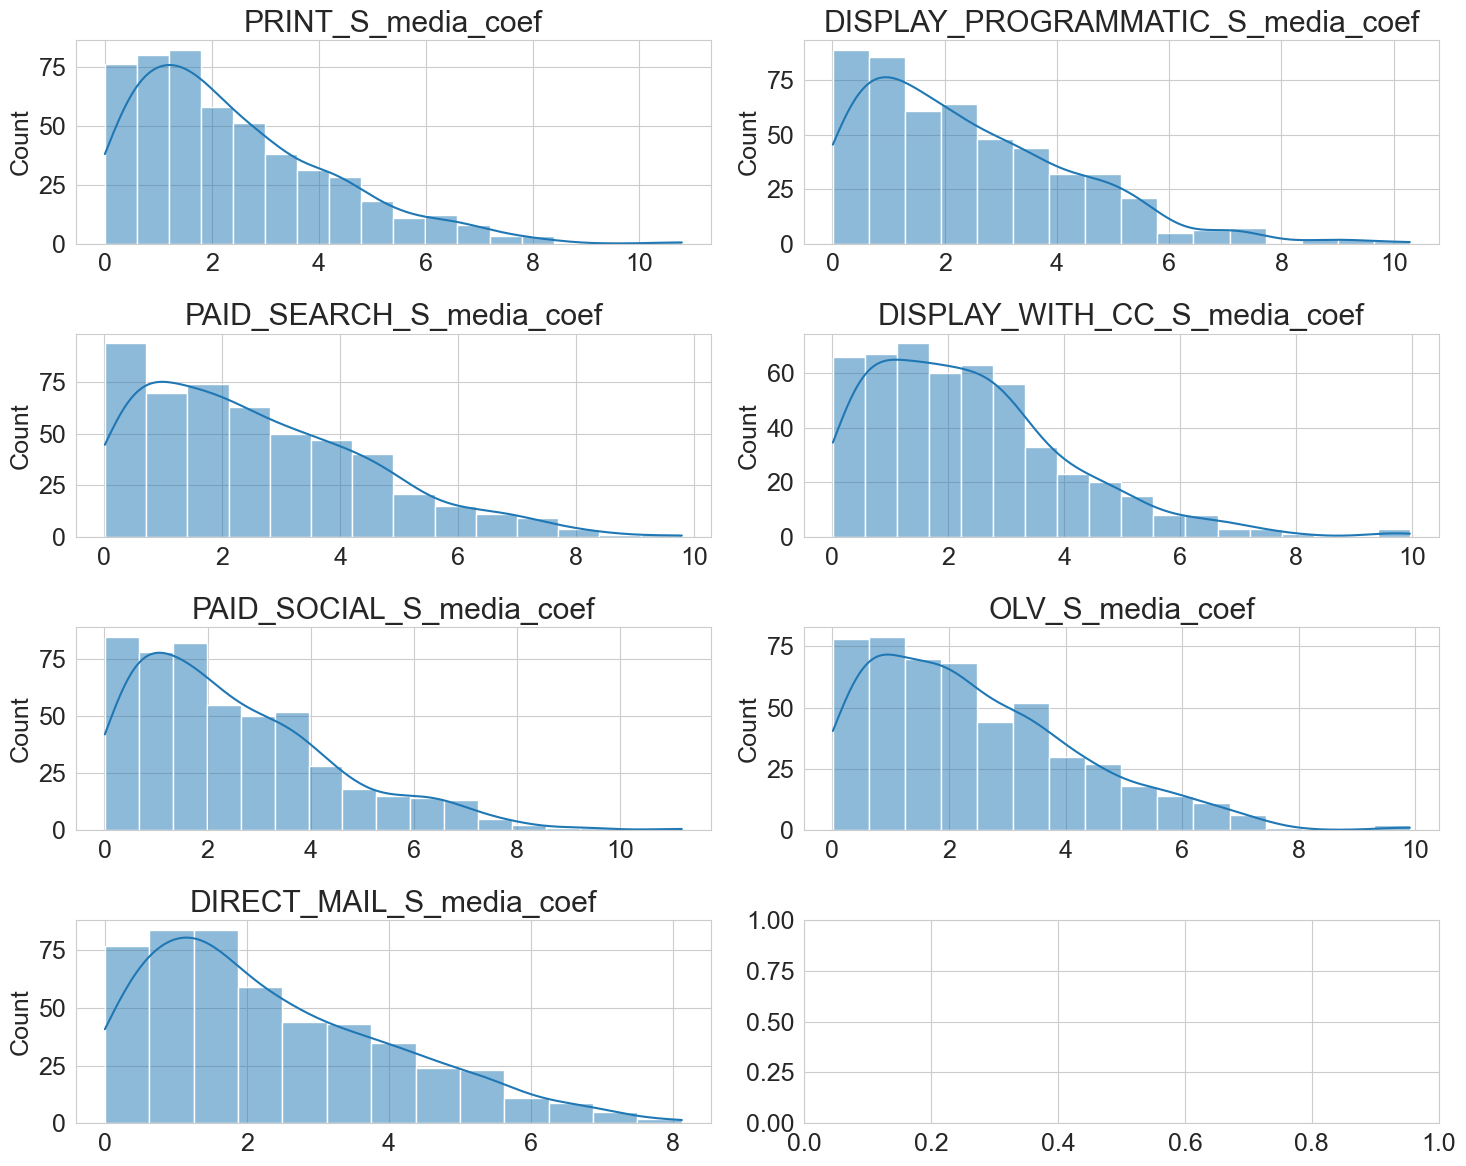

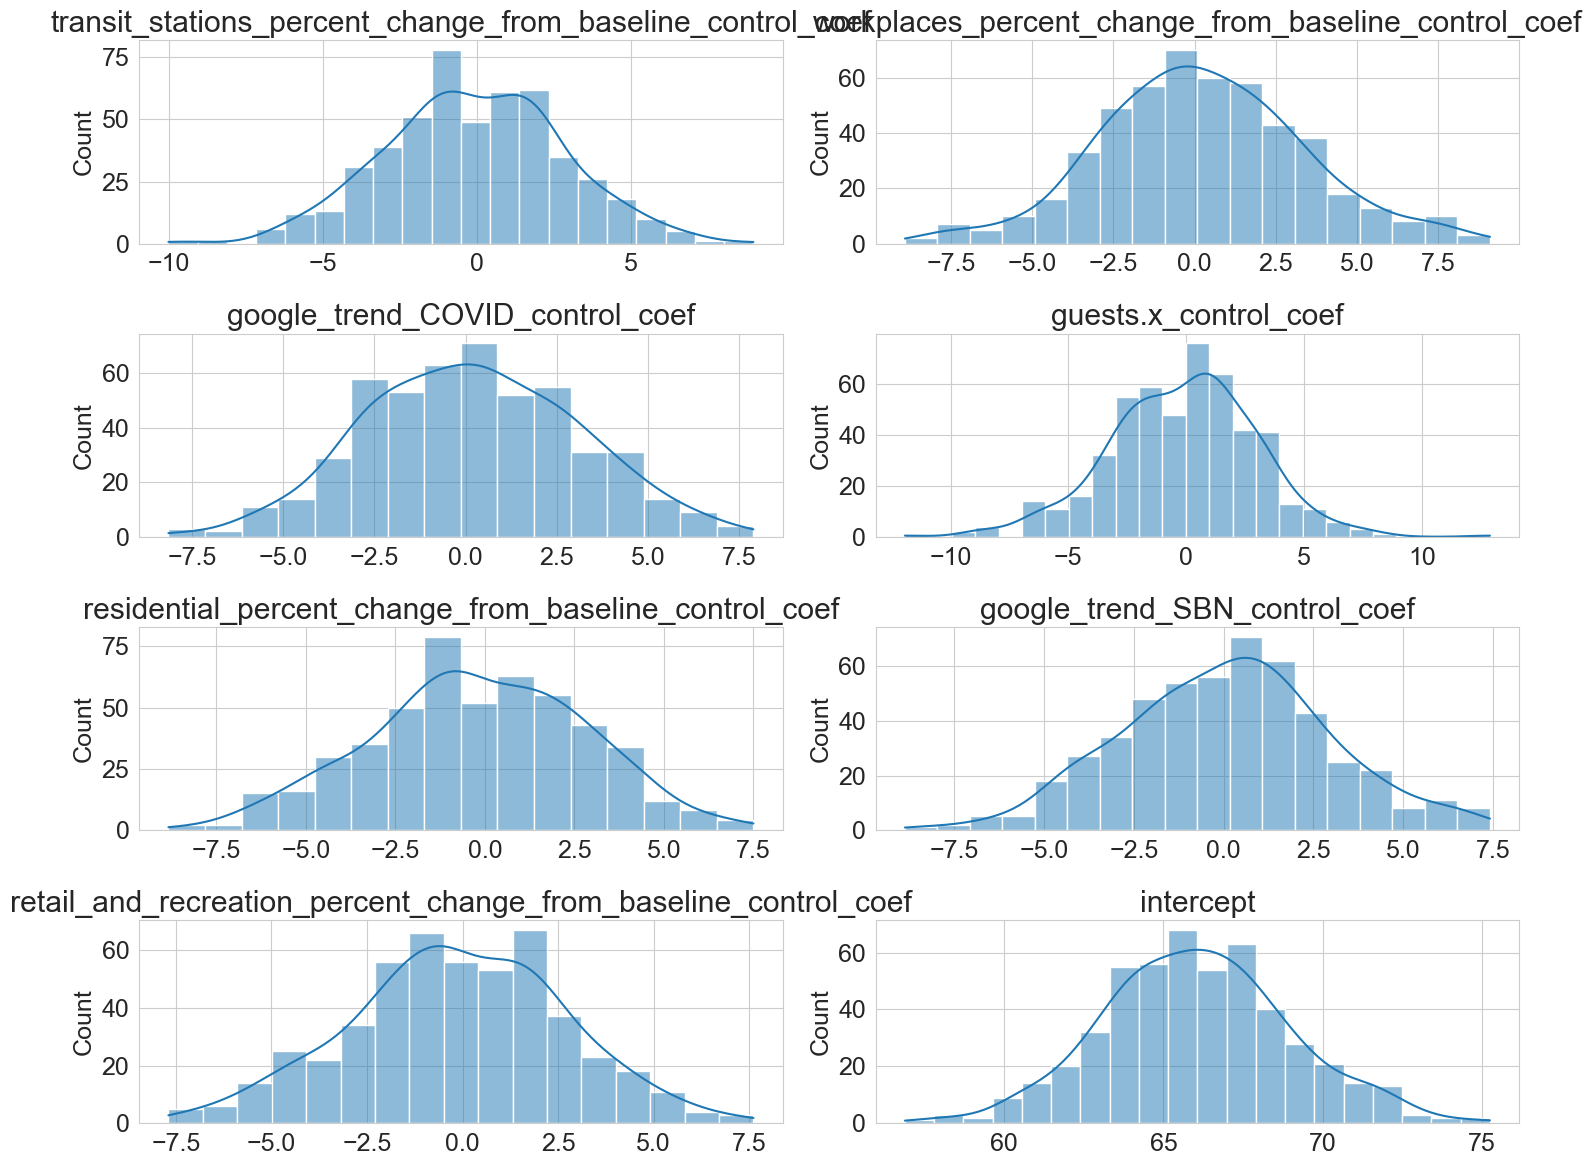

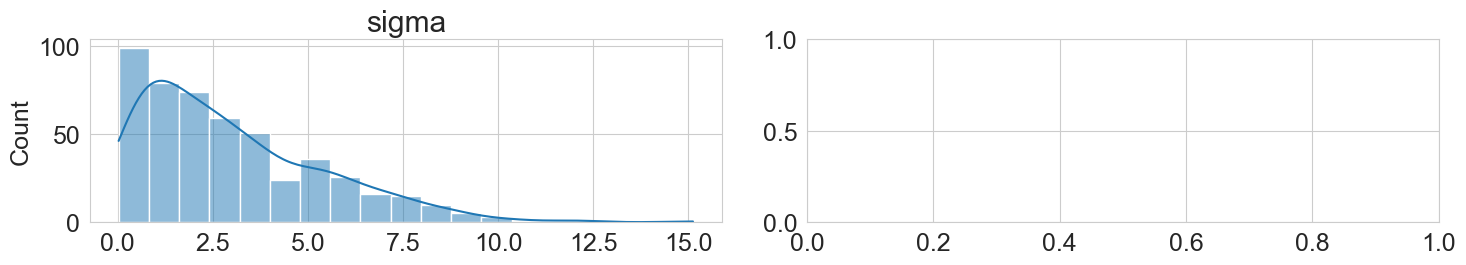

In [133]:
adstock_priors = [p for p in prior_names if p.endswith("adstock")]
plot_priors(adstock_priors, prior_pred)
print(f"adstock priors: {len(adstock_priors)}")

alpha_priors = [p for p in prior_names if p.endswith("alpha")]
plot_priors(alpha_priors, prior_pred)
print(f"alpha priors: {len(alpha_priors)}")

gamma_priors = [p for p in prior_names if p.endswith("gamma")]
plot_priors(gamma_priors, prior_pred)
print(f"gamma priors: {len(gamma_priors)}")


media_coef_priors = [p for p in prior_names if p.endswith("media_coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"media coef priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.endswith("control_coef")] + ["intercept"]
plot_priors(control_coef_priors, prior_pred)
print(f"control coef priors: {len(control_coef_priors)}")

plot_priors(["sigma"], prior_pred)
print(f"sigma prior: 1")

In [139]:
# This is the process that takes several minutes
# 30 Min

In [134]:
with model_2:
    trace = pm.sample(1000, tune=1000, step=None, target_accept = 0.95, return_inferencedata=True)
    trace_summary = az.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, residential_percent_change_from_baseline_control_coef, retail_and_recreation_percent_change_from_baseline_control_coef, workplaces_percent_change_from_baseline_control_coef, transit_stations_percent_change_from_baseline_control_coef, google_trend_COVID_control_coef, google_trend_SBN_control_coef, guests.x_control_coef, OLV_S_media_coef, OLV_S_alpha, OLV_S_gamma, OLV_S_adstock, PAID_SOCIAL_S_media_coef, PAID_SOCIAL_S_alpha, PAID_SOCIAL_S_gamma, PAID_SOCIAL_S_adstock, DISPLAY_WITH_CC_S_media_coef, DISPLAY_WITH_CC_S_alpha, DISPLAY_WITH_CC_S_gamma, DISPLAY_WITH_CC_S_adstock, DISPLAY_PROGRAMMATIC_S_media_coef, DISPLAY_PROGRAMMATIC_S_alpha, DISPLAY_PROGRAMMATIC_S_gamma, DISPLAY_PROGRAMMATIC_S_adstock, PAID_SEARCH_S_media_coef, PAID_SEARCH_S_alpha, PAID_SEARCH_S_gamma, PAID_SEARCH_S_adstock, PRINT_S_media_coef, PRINT_S_alpha, PRINT_S_gamma, PRINT_S_ad

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1648 seconds.
/Users/gerardogandara/opt/anaconda3/envs/py3913/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.


In [135]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
guests.x_control_coef,0.05000,0.00500,0.04200,0.05900,0.00000,0.00000,3958.00000,2649.00000,1.00000
google_trend_SBN_control_coef,0.13100,0.10300,-0.06800,0.32400,0.00200,0.00100,2793.00000,2471.00000,1.00000
google_trend_COVID_control_coef,-0.05800,0.11500,-0.27600,0.15600,0.00200,0.00200,3961.00000,2618.00000,1.00000
transit_stations_percent_change_from_baseline_control_coef,2.45400,0.38300,1.74500,3.18600,0.00700,0.00500,3334.00000,2439.00000,1.00000
workplaces_percent_change_from_baseline_control_coef,0.67200,0.30300,0.13100,1.24600,0.00600,0.00400,2909.00000,2686.00000,1.00000
retail_and_recreation_percent_change_from_baseline_control_coef,-1.43900,0.62900,-2.66200,-0.29400,0.01200,0.00800,2876.00000,2546.00000,1.00000
residential_percent_change_from_baseline_control_coef,1.57900,1.38000,-0.84800,4.34100,0.02200,0.01700,3873.00000,3066.00000,1.00000
intercept,64.38700,2.91700,58.76800,69.81900,0.04100,0.02900,5159.00000,2701.00000,1.00000
DIRECT_MAIL_S_adstock,0.48800,0.18600,0.13300,0.81700,0.00200,0.00200,5819.00000,2524.00000,1.00000
DIRECT_MAIL_S_gamma,0.50000,0.23000,0.08700,0.88300,0.00300,0.00200,5153.00000,1884.00000,1.00000


In [140]:
# Another 10 min

In [136]:
with model_2:
    ppc_all = pm.sample_posterior_predictive(
        trace, var_names=["outcome"] + list(trace_summary.index), random_seed=42
    )

/Users/gerardogandara/opt/anaconda3/envs/py3913/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


<Axes: xlabel='outcome / outcome'>

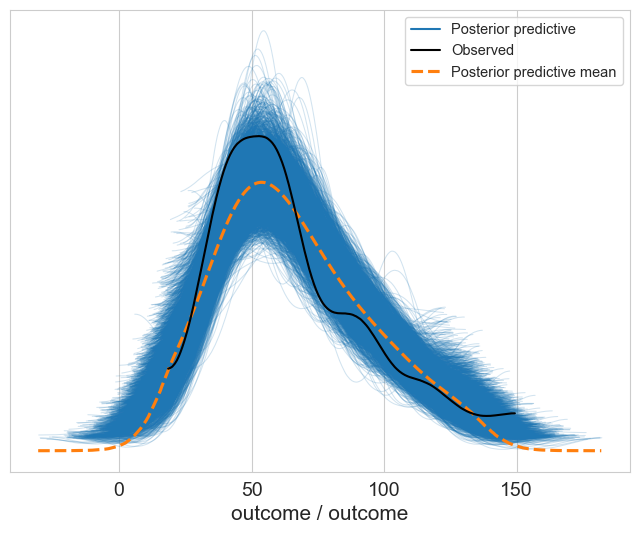

In [137]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_all, model=model_2), var_names = ["outcome"])


In [138]:
from sklearn.metrics import r2_score

trace_summary = az.summary(trace)
trace_summary = trace_summary.rename(columns={'mean': 'old_mean'})
trace_summary["mean"] = np.inf


for variable in list(trace_summary.index):
    #mean_variable = ppc_all[variable].mean()
    mean_variable = trace.posterior[variable].mean(axis = 0).mean().values
    trace_summary.loc[trace_summary.index == variable, "mean"] = mean_variable


y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = ppc_all["outcome"].mean(axis = 0) * 100_000

print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")
print(f"R2: {r2_score(y_true, y_pred)}")

RMSE: 1222009.9992540139
MAPE: 0.13960552193709075
NRMSE: 0.09321971303597464
R2: 0.8149140658937056


# Residuals

In [141]:
plot = plot_residuals(pd.DataFrame({"actual": y_true, "predicted": y_pred}), figure_size = (15, 5))


# Decomposition

In [144]:
adstock_params = trace_summary[trace_summary.index.str.contains("adstock")][["mean", "sd"]].reset_index().rename(columns = {'index': 'name'}).assign(name = lambda x: x["name"].str.replace("_adstock", ""))
saturation_params = pd.merge(
    trace_summary[trace_summary.index.str.contains("gamma")][["mean"]].reset_index().rename(columns = {'mean': 'gamma'}).assign(name = lambda x: x["index"].str.replace("_gamma", "")), 
    trace_summary[trace_summary.index.str.contains("alpha")][["mean"]].reset_index().rename(columns = {'mean': 'alpha'}).assign(name = lambda x: x["index"].str.replace("_alpha", "")), on = "name" )
control_coefficients = trace_summary[trace_summary.index.str.contains("_control_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_control_coef", ""))
delay_coefficients = trace_summary[trace_summary.index.str.contains("_media_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_media_coef", ""))


In [145]:
data_transformed_decomposed = data_transformed.copy()
intercept = trace_summary[trace_summary.index == "intercept"]["mean"].iloc[0]
data_transformed_decomposed["intercept"] = intercept
print(f"Intercept: {intercept}")

for delay_channel in delay_channels:
    print(delay_channel)
    
    adstock = adstock_params[adstock_params.name == delay_channel]
    adstock_theta = adstock["mean"].iloc[0]
    
    print(f"\tadstock {adstock_theta} transformation")
    
    data_transformed_decomposed[delay_channel] = adstock_geometric(data_transformed_decomposed[delay_channel].values, theta = adstock_theta)
    
    saturation = saturation_params[saturation_params.name == delay_channel]
    
    saturation_alpha = saturation["alpha"].iloc[0]
    saturation_gamma = saturation["gamma"].iloc[0]
    
    print(f"\tsaturation alpha {saturation_alpha}, gamma {saturation_gamma} transformation")
    
    #use the unbound version of saturation
    data_transformed_decomposed[delay_channel] = saturation_hill_pymc3(data_transformed_decomposed[delay_channel].values, alpha = saturation_alpha, gamma = saturation_gamma)
    
    coefs = delay_coefficients[delay_coefficients.name == delay_channel]
    coef = coefs["mean"].iloc[0]
    
    data_transformed_decomposed[delay_channel] = data_transformed_decomposed[delay_channel] * coef
    print(f"\tcoefficient: {coef}")
    
#apply coefficients

for variable in control_variables:
    coefs = control_coefficients[control_coefficients.name == variable]
    coef = coefs["mean"].iloc[0]
    print(f"Control Coefficient: {variable}: {coef}")
    data_transformed_decomposed[variable] = data_transformed_decomposed[variable] * coef
    

Intercept: 64.38708654913479
DIRECT_MAIL_S
	adstock 0.4880398519971345 transformation
	saturation alpha 2.9466723077030084, gamma 0.5004350414361948 transformation
	coefficient: 1.89427558442885
PRINT_S
	adstock 0.44668270947183064 transformation
	saturation alpha 3.135904077305283, gamma 0.542511713333676 transformation
	coefficient: 2.6503136336342847
PAID_SEARCH_S
	adstock 0.4578608246934276 transformation
	saturation alpha 3.056595031228768, gamma 0.530943815613822 transformation
	coefficient: 2.309458580490366
DISPLAY_PROGRAMMATIC_S
	adstock 0.47773148410601096 transformation
	saturation alpha 2.9663818335050958, gamma 0.49424146909038036 transformation
	coefficient: 2.466520240824645
DISPLAY_WITH_CC_S
	adstock 0.4739783692674796 transformation
	saturation alpha 2.861307001297503, gamma 0.5031780361900515 transformation
	coefficient: 1.7971986197257939
PAID_SOCIAL_S
	adstock 0.5087911964668662 transformation
	saturation alpha 2.8820506892476607, gamma 0.5002962527562981 transforma

RMSE: 1224598.497311872
MAPE: 0.13908080567285377
NRMSE: 0.09321971303597464
R2: 0.8149140658937056


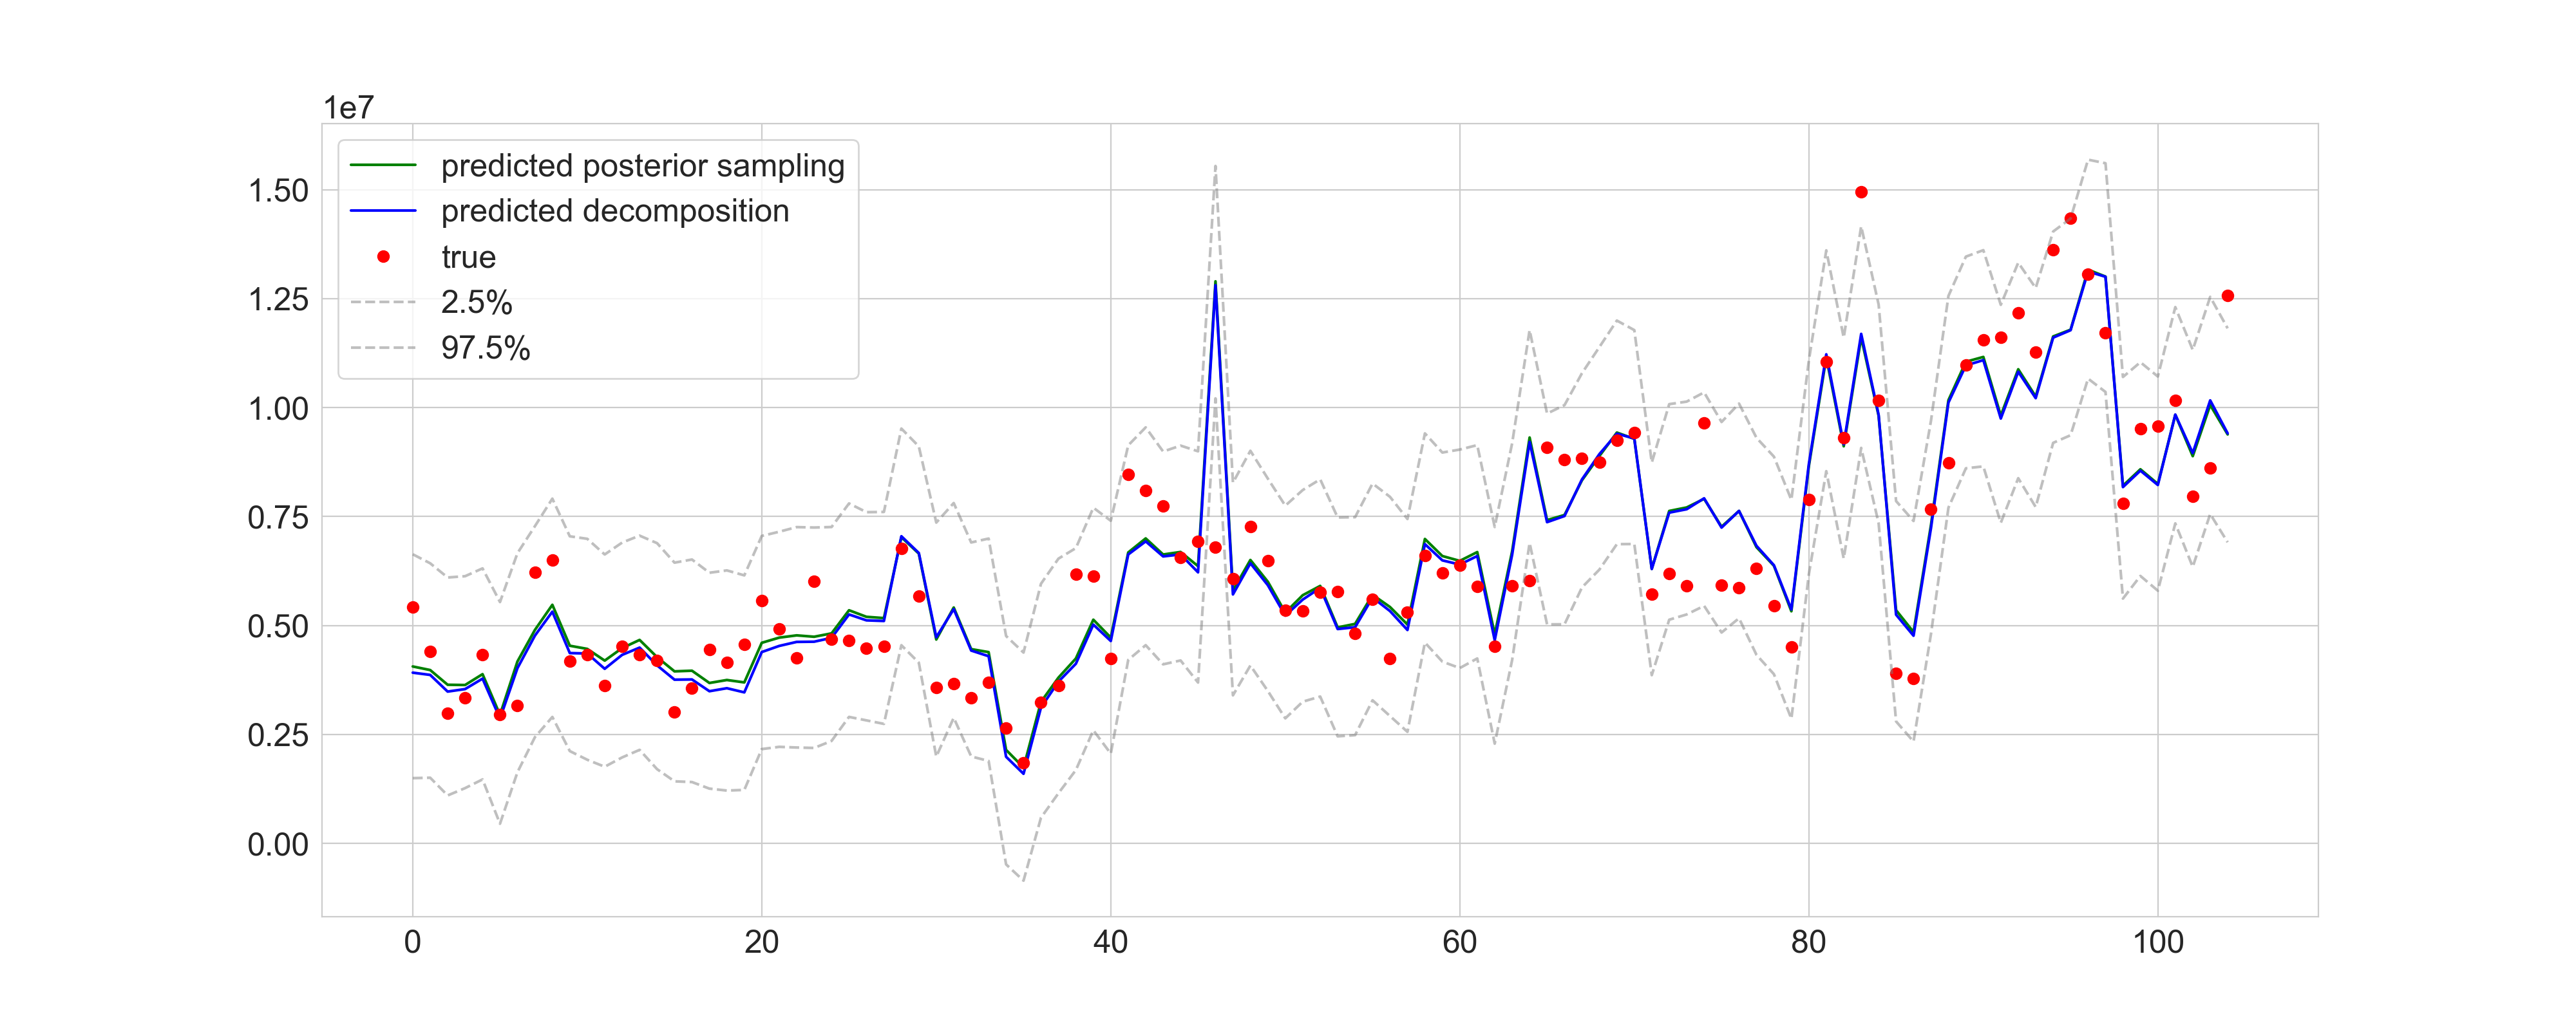

In [146]:
data_transformed_decomposed["prediction"] = data_transformed_decomposed[delay_channels + control_variables + ["intercept"]].sum(axis = 1)
y_pred_decomposed = data_transformed_decomposed["prediction"].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX] * 100_000


print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred_decomposed)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred_decomposed) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")
print(f"R2: {r2_score(y_true, y_pred)}")
qs = mquantiles(100_000 * (ppc_all["outcome"]), [0.025, 0.975], axis=0)
qs_decomposed = mquantiles(100_000 * (ppc_all["outcome"]), [0.025, 0.975], axis=0)
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot((ppc_all["outcome"].mean(axis = 0) * 100_000), color = "green", label = "predicted posterior sampling")
_ = ax.plot(y_pred_decomposed, color = "blue", label = "predicted decomposition")
_ = ax.plot(data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], 'ro', label = "true")
_ = ax.plot(qs[0], '--', color = "grey", label = "2.5%", alpha = 0.5)
_ = ax.plot(qs[1], '--', color = "grey", label = "97.5%", alpha = 0.5)
_ = ax.legend()

In [148]:
spend_df = pd.DataFrame()
for media_channel in media_channels:
    temp_series = data[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    
    ##exposure to spend should
    #if len(media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]) > 0:
        
    #    vmax = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["V_max"].iloc[0]
    #    km = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["K_m"].iloc[0]
    #    spends = exposure_to_spend_menten_func(temp_series, V_max = vmax, K_m = km)
    #    spends_total = spends.sum()
    #else:
    #    spends_total = temp_series.sum()
    spends_total = temp_series.sum()
        
    spend_df = pd.concat([spend_df, pd.DataFrame({'media': [media_channel], 'total_spend': [spends_total]})]).reset_index(drop=True)

spend_df["spend_share"] = spend_df["total_spend"] / spend_df["total_spend"].sum()
spend_df

,media,total_spend,spend_share
0,DIRECT_MAIL_S,12494977.68500,0.33631
1,PRINT_S,5100045.78000,0.13727
2,PAID_SEARCH_S,6922898.88943,0.18633
3,DISPLAY_PROGRAMMATIC_S,2910759.85194,0.07835
4,DISPLAY_WITH_CC_S,2548734.69519,0.06860
5,PAID_SOCIAL_S,3698578.12939,0.09955
6,OLV_S,3477044.05095,0.09359


In [149]:
response_df = pd.DataFrame()
for media_channel in media_channels:
    response = data_transformed_decomposed[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    response_total = response.sum()
    
    response_df = pd.concat([response_df, pd.DataFrame({'media': [media_channel], 'total_effect': [response_total]})]).reset_index(drop=True)
response_df["effect_share"] = response_df["total_effect"] / response_df["total_effect"].sum()

response_df

,media,total_effect,effect_share
0,DIRECT_MAIL_S,116.48869,0.18889
1,PRINT_S,97.34659,0.15785
2,PAID_SEARCH_S,138.17676,0.22406
3,DISPLAY_PROGRAMMATIC_S,95.26141,0.15447
4,DISPLAY_WITH_CC_S,30.06959,0.04876
5,PAID_SOCIAL_S,43.66968,0.07081
6,OLV_S,95.68825,0.15516


In [151]:
response_df.sort_values(by='effect_share', ascending = False)

,media,total_effect,effect_share
2,PAID_SEARCH_S,138.17676,0.22406
0,DIRECT_MAIL_S,116.48869,0.18889
1,PRINT_S,97.34659,0.15785
6,OLV_S,95.68825,0.15516
3,DISPLAY_PROGRAMMATIC_S,95.26141,0.15447
5,PAID_SOCIAL_S,43.66968,0.07081
4,DISPLAY_WITH_CC_S,30.06959,0.04876


In [152]:
spend_response_share_df = pd.concat([spend_df, response_df.drop(columns=["media"])], axis = 1)
spend_response_share_df

,media,total_spend,spend_share,total_effect,effect_share
0,DIRECT_MAIL_S,12494977.68500,0.33631,116.48869,0.18889
1,PRINT_S,5100045.78000,0.13727,97.34659,0.15785
2,PAID_SEARCH_S,6922898.88943,0.18633,138.17676,0.22406
3,DISPLAY_PROGRAMMATIC_S,2910759.85194,0.07835,95.26141,0.15447
4,DISPLAY_WITH_CC_S,2548734.69519,0.06860,30.06959,0.04876
5,PAID_SOCIAL_S,3698578.12939,0.09955,43.66968,0.07081
6,OLV_S,3477044.05095,0.09359,95.68825,0.15516


In [153]:
spend_response_share_df = pd.concat([spend_df, response_df.drop(columns=["media"])], axis = 1)
spend_response_share_df

,media,total_spend,spend_share,total_effect,effect_share
0,DIRECT_MAIL_S,12494977.68500,0.33631,116.48869,0.18889
1,PRINT_S,5100045.78000,0.13727,97.34659,0.15785
2,PAID_SEARCH_S,6922898.88943,0.18633,138.17676,0.22406
3,DISPLAY_PROGRAMMATIC_S,2910759.85194,0.07835,95.26141,0.15447
4,DISPLAY_WITH_CC_S,2548734.69519,0.06860,30.06959,0.04876
5,PAID_SOCIAL_S,3698578.12939,0.09955,43.66968,0.07081
6,OLV_S,3477044.05095,0.09359,95.68825,0.15516


In [154]:
spend_response_share_df.sort_values(by='effect_share', ascending=False)

,media,total_spend,spend_share,total_effect,effect_share
2,PAID_SEARCH_S,6922898.88943,0.18633,138.17676,0.22406
0,DIRECT_MAIL_S,12494977.68500,0.33631,116.48869,0.18889
1,PRINT_S,5100045.78000,0.13727,97.34659,0.15785
6,OLV_S,3477044.05095,0.09359,95.68825,0.15516
3,DISPLAY_PROGRAMMATIC_S,2910759.85194,0.07835,95.26141,0.15447
5,PAID_SOCIAL_S,3698578.12939,0.09955,43.66968,0.07081
4,DISPLAY_WITH_CC_S,2548734.69519,0.06860,30.06959,0.04876


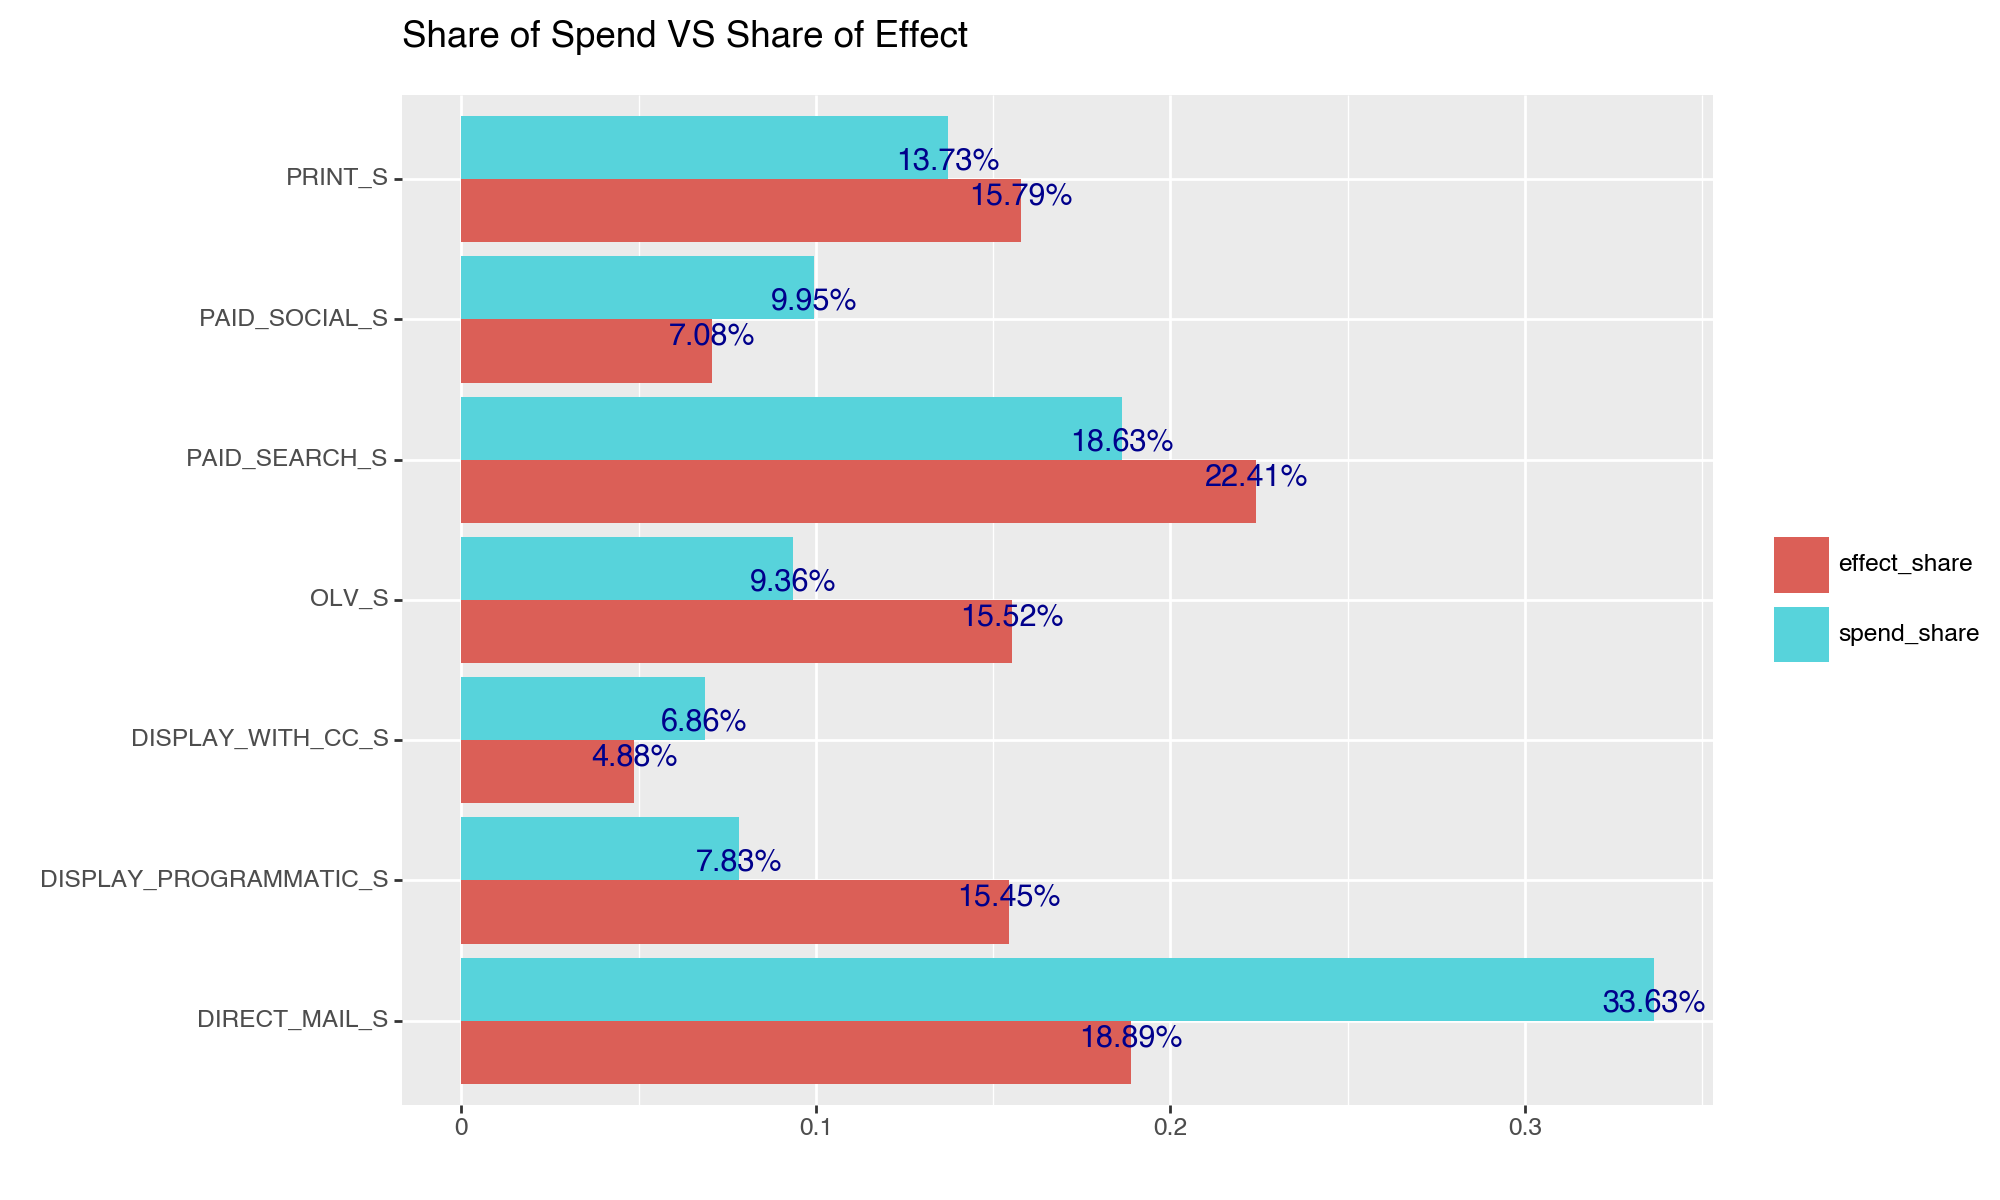

<Figure Size: (1000 x 600)>

In [155]:
plot_spend_vs_effect_share(spend_response_share_df, figure_size = (10, 6))


# END